In [1]:
import numpy as np
import pandas as pd  
import xarray as xr 
import matplotlib.pyplot as plt 
import os 

In [3]:
# updated codes based on 19 variables
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

def get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg='', season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    RMSEav = []
    amp_errav  = []
    pha_errav = []
    BCCav = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = tsta + np.timedelta64(1819, 'D')

    # RMM index in all seasons, amplitudes and phases.
    # fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    if mjo_ind=='RMM':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1979to2012.nc'
    elif mjo_ind=='ROMI':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/ROMI_ERA5_daily_1979to2021.nc'

    dsrmm0 = xr.open_dataset(Fnmjo)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm[mjo_ind][:,0]
    RMMi2 = dsrmm[mjo_ind][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        # fn = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/19maps_MCDO_ERA5_yproj_xfft_4gpus/output/predicted_MCDO_UNET_'+dataflg+vn+str(lat_range)+'deg_'+mjo_ind+'ERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'
        fn = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus_new/output/predicted_MCDO_UNET_'+vn+str(lat_range)+'deg_'+mjo_ind+'ERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_c51_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn[mjo_ind+'t'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))[mjo_ind].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC 
        r1p = np.asarray(dsfn_sel[mjo_ind+'p'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel[mjo_ind+'p'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel[mjo_ind+'t'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel[mjo_ind+'t'][:,1]).reshape((-1, 1))

        # BCC 
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCCav.append(a/b/c) 

        # RMSE [time]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSEav.append(np.sqrt(np.mean(d)))  # RMSE at each time step

        # phase error [time]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_errav.append(np.mean(d))

        # amplitude error [time] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_errav.append(np.mean(c))

        Nsamp = np.shape(dsfn_sel[mjo_ind+'p_dis'])[1]

        RMSEdp = []
        amp_errdp  = []
        pha_errdp = []
        BCCdp = []

        for idp in range(Nsamp):
            # calculate BCC 
            r1p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,idp,0]).reshape((-1, 1))
            r2p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,idp,1]).reshape((-1, 1))

            # BCC 
            a = np.sum(r1p*r1t+r2p*r2t, axis=0)
            b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
            c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
            BCCdp.append(a/b/c) 

            # RMSE 
            d = np.mean((r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p))
            RMSEdp.append(np.sqrt(d))  

            # phase error 
            a = r1t * r2p - r2t * r1p 
            b = r1t * r1p + r2t * r2p
            c = a / b 
            d = np.arctan(c) * 180. / np.pi
            pha_errdp.append(np.mean(d))

            # amplitude error [time] truth - prediction
            a = np.sqrt(r1p*r1p+r2p*r2p)
            b = np.sqrt(r1t*r1t+r2t*r2t)
            c = b - a 
            amp_errdp.append(np.mean(c))

        BCC.append(BCCdp)
        RMSE.append(RMSEdp)
        amp_err.append(amp_errdp)
        pha_err.append(pha_errdp)
        
        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav

def get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg='', season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    RMSEav = []
    amp_errav  = []
    pha_errav = []
    BCCav = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = tsta + np.timedelta64(1819, 'D')

    # RMM index in all seasons, amplitudes and phases.
    # fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    if mjo_ind=='RMM':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1979to2012.nc'
    elif mjo_ind=='ROMI':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/ROMI_ERA5_daily_1979to2021.nc'

    dsrmm0 = xr.open_dataset(Fnmjo)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm[mjo_ind][:,0]
    RMMi2 = dsrmm[mjo_ind][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus_new/output/predicted_MCDO_UNET_'+vn+str(lat_range)+'deg_'+mjo_ind+'ERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_c51_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn[mjo_ind+'t'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))[mjo_ind].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)
        Nsamp = np.shape(dsfn_sel[mjo_ind+'p_dis'])[1]

        # calculate BCC 
        r1p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,:,0]).reshape((-1, Nsamp))
        r2p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,:,1]).reshape((-1, Nsamp))

        r1p0 = np.asarray(dsfn_sel[mjo_ind+'p'][:,0]).reshape((-1, 1))
        r2p0 = np.asarray(dsfn_sel[mjo_ind+'p'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel[mjo_ind+'t'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel[mjo_ind+'t'][:,1]).reshape((-1, 1))

        # BCC 
        a = r1p*r1t+r2p*r2t  # [time, Nsamp]
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = np.sqrt(r1p*r1p+r2p*r2p)
        d = np.mean(a/b/c, axis=0)  # average over different initial conditions
        BCC.append(d) 

        # BCC 
        a = r1p0*r1t+r2p0*r2t  # [time, 1]
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = np.sqrt(r1p0*r1p0+r2p0*r2p0)
        d = np.mean(a/b/c)  # average over different initial conditions
        BCCav.append(d) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append( np.mean(np.sqrt(d), axis=0) ) # RMSE averaged over different initial conditions [Nsamp]

        # RMSE [time, 1]
        d = (r1t-r1p0)*(r1t-r1p0)+(r2t-r2p0)*(r2t-r2p0)
        RMSEav.append( np.mean(np.sqrt(d)) ) # RMSE averaged over different initial conditions [Nsamp]

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append( np.mean(d, axis=0) )

        # phase error [time, 1]
        a = r1t * r2p0 - r2t * r1p0 
        b = r1t * r1p0 + r2t * r2p0
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_errav.append( np.mean(d) )

        # amplitude error [time] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_err.append( np.mean(c, axis=0) )

        # amplitude error [time] truth - prediction
        a = np.sqrt(r1p0*r1p0+r2p0*r2p0)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_errav.append( np.mean(c) )


        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav

def get_figure(BCCdp, RMSEdp, pha_errdp, amp_errdp, ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].fill_between(lead, np.min(np.asarray(BCCdp),axis=1).squeeze(), np.max(np.asarray(BCCdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[0,1].fill_between(lead, np.min(np.asarray(RMSEdp),axis=1).squeeze(), np.max(np.asarray(RMSEdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,1].fill_between(lead, np.min(np.asarray(amp_errdp),axis=1).squeeze(), np.max(np.asarray(amp_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,0].fill_between(lead, np.min(np.asarray(pha_errdp),axis=1).squeeze(), np.max(np.asarray(pha_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

def get_figure_q(BCCdp, RMSEdp, pha_errdp, amp_errdp, ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    p1 = 25
    p2 = 75
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].fill_between(lead, np.percentile(np.asarray(BCCdp).squeeze(), p1, axis=1), np.percentile(np.asarray(BCCdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    # avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, RMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[0,1].fill_between(lead, np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1), np.percentile(np.asarray(RMSEdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    # ax[0,1].legend(fontsize=12)

    # avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, amp_err, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,1].fill_between(lead, np.percentile(np.asarray(amp_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(amp_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    # avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, pha_err, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,0].fill_between(lead, np.percentile(np.asarray(pha_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(pha_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    ax[1,0].legend(fontsize=12)

    tmp = np.asarray(np.percentile(np.asarray(BCCdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(BCCdp).squeeze(),p1,axis=1).squeeze())
    ax[2,0].plot(lead, tmp, 'o-', linewidth=3,label=label_flg)
    ax[2,0].grid(visible=True)
    ax[2,0].set_xlabel('lead (days)')
    ax[2,0].set_ylabel('model uncertainty (bulk BCC)')

    tmp = np.asarray(np.percentile(np.asarray(RMSEdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1).squeeze())
    ax[2,1].plot(lead, tmp, 'o-', linewidth=3,label=label_flg)
    ax[2,1].grid(visible=True)
    ax[2,1].set_xlabel('lead (days)')
    ax[2,1].set_ylabel('model uncertainty (bulk RMSE)')

def get_figure_model_un(BCCdp, RMSEdp, pha_errdp, amp_errdp, BCC, RMSE, pha_err, amp_err, ax, lead, label_flg):
    p1 = 25
    p2 = 75
    
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg)
    ax[0,0].fill_between(lead, np.percentile(np.asarray(BCCdp).squeeze(), p1, axis=1), np.percentile(np.asarray(BCCdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')

    # linec = ax[0,0].lines[-1].get_color()
    # ax_right.set_ylabel('model uncertainty (individual)')
    # tmp = np.asarray(np.percentile(np.asarray(BCCdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(BCCdp).squeeze(),p1,axis=1).squeeze())
    # ax_right.plot(lead, tmp,'o--', linewidth=3, color=linec)
    # # ax[0,0].legend()

    ax[0,1].plot(lead, RMSE, 'o-', linewidth=3, label=label_flg)
    ax[0,1].fill_between(lead, np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1), np.percentile(np.asarray(RMSEdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')

    # # ax[0,1].legend(fontsize=12)
    # ax_right1.set_ylabel('model uncertainty (individual)')
    # tmp = np.asarray(np.percentile(np.asarray(RMSEdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1).squeeze())
    # print(np.shape(tmp))
    # ax_right1.plot(lead, tmp,'o--', linewidth=3, color=linec)
    # # ax[0,0].legend()

    ax[1,1].plot(lead, amp_err, 'o-', linewidth=3, label=label_flg)
    ax[1,1].fill_between(lead, np.percentile(np.asarray(amp_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(amp_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    ax[1,0].plot(lead, pha_err, 'o-', linewidth=3,label=label_flg)
    ax[1,0].fill_between(lead, np.percentile(np.asarray(pha_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(pha_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    ax[1,0].legend(fontsize=12)

    tmp = np.asarray(np.percentile(np.asarray(BCCdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(BCCdp).squeeze(),p1,axis=1).squeeze())
    ax[2,0].plot(lead, tmp, 'o-', linewidth=3,label=label_flg)
    ax[2,0].grid(visible=True)
    ax[2,0].set_xlabel('lead (days)')
    ax[2,0].set_ylabel('model uncertainty (individual BCC)')

    tmp = np.asarray(np.percentile(np.asarray(RMSEdp).squeeze(), p2, axis=1).squeeze() - np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1).squeeze())
    ax[2,1].plot(lead, tmp, 'o-', linewidth=3,label=label_flg)
    ax[2,1].grid(visible=True)
    ax[2,1].set_xlabel('lead (days)')
    ax[2,1].set_ylabel('model uncertainty (individual RMSE)')



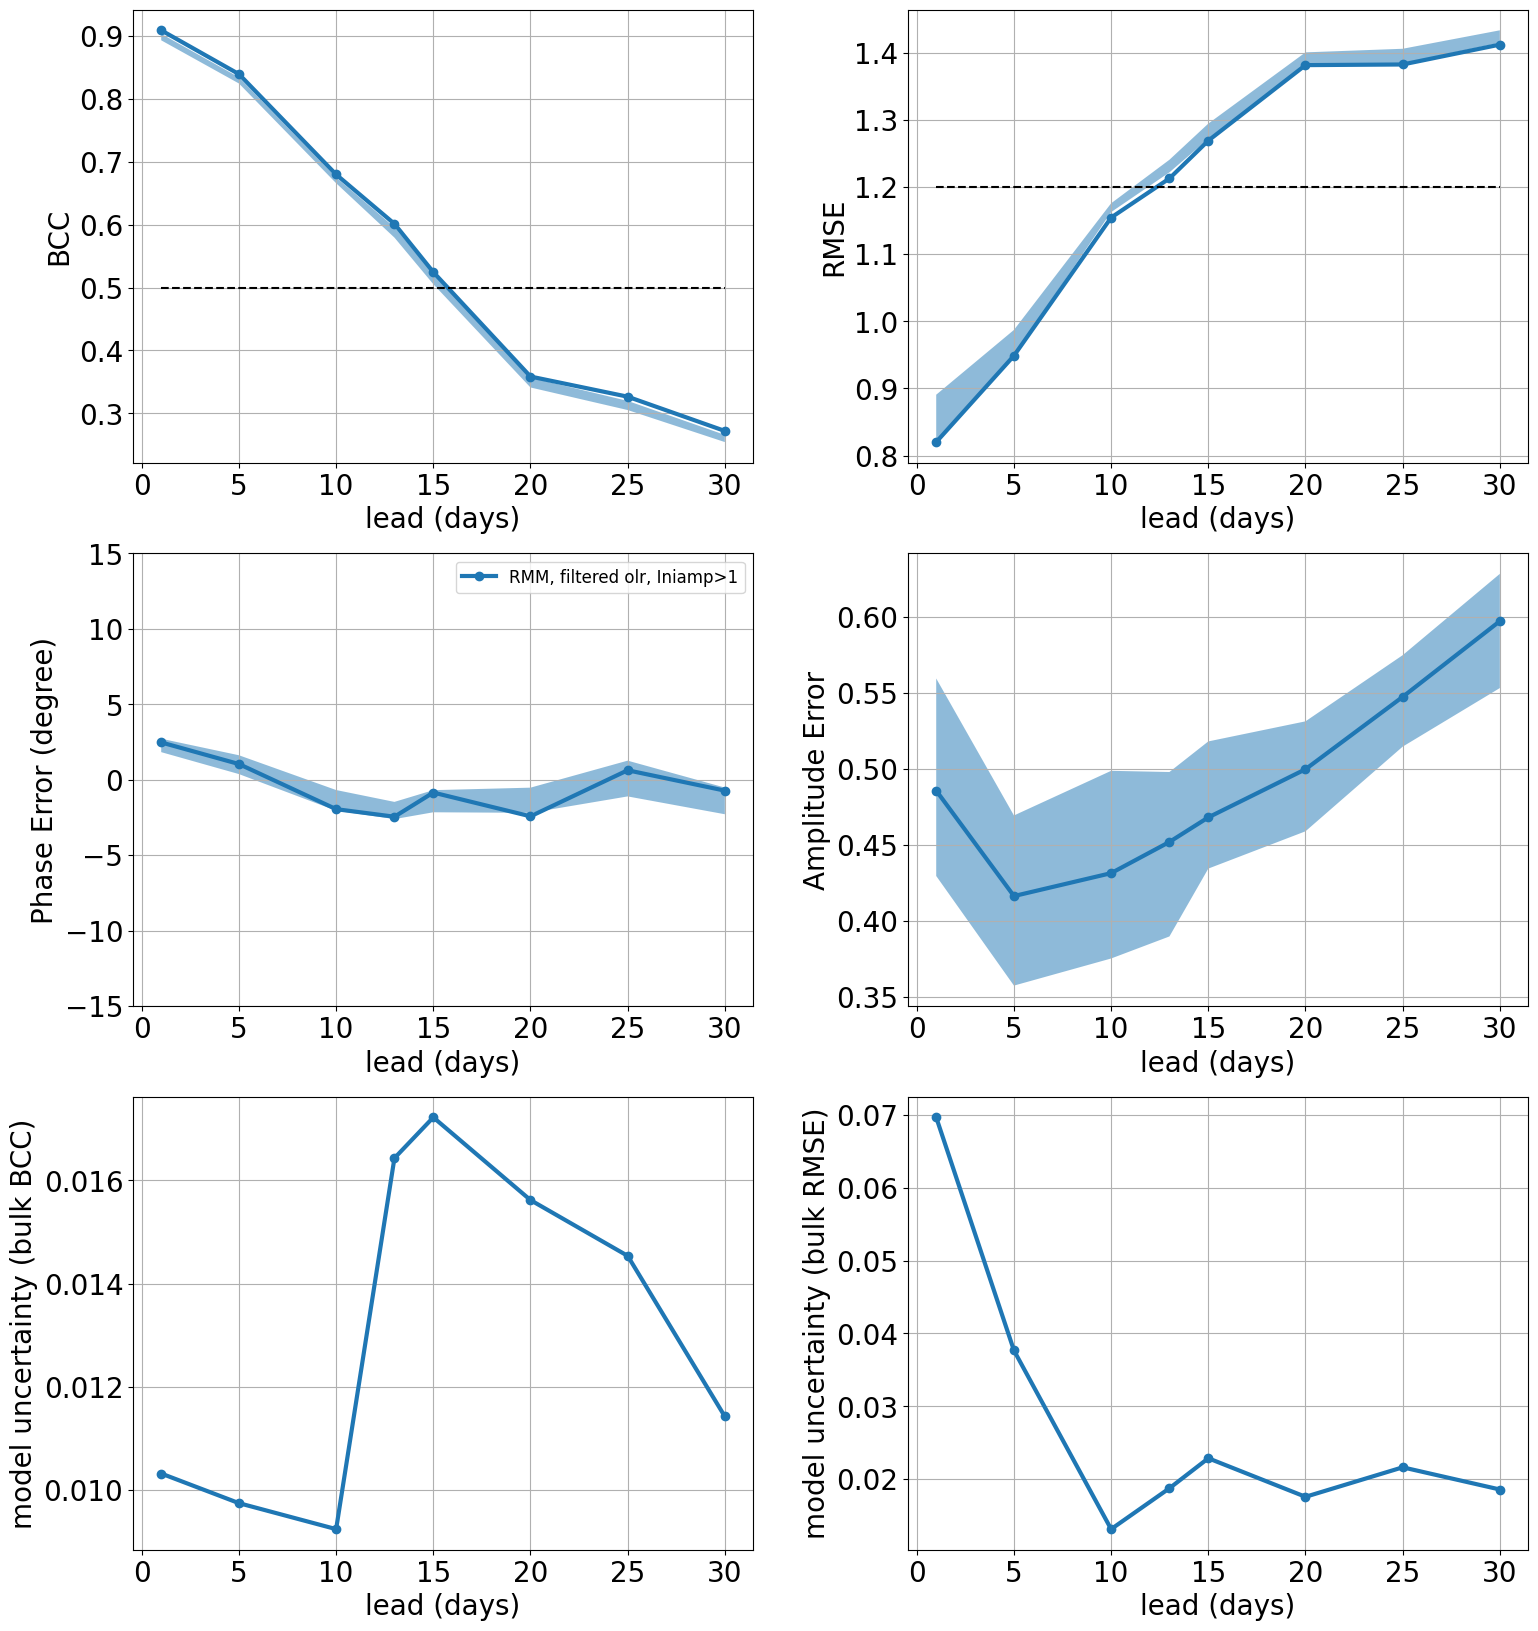

In [5]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))


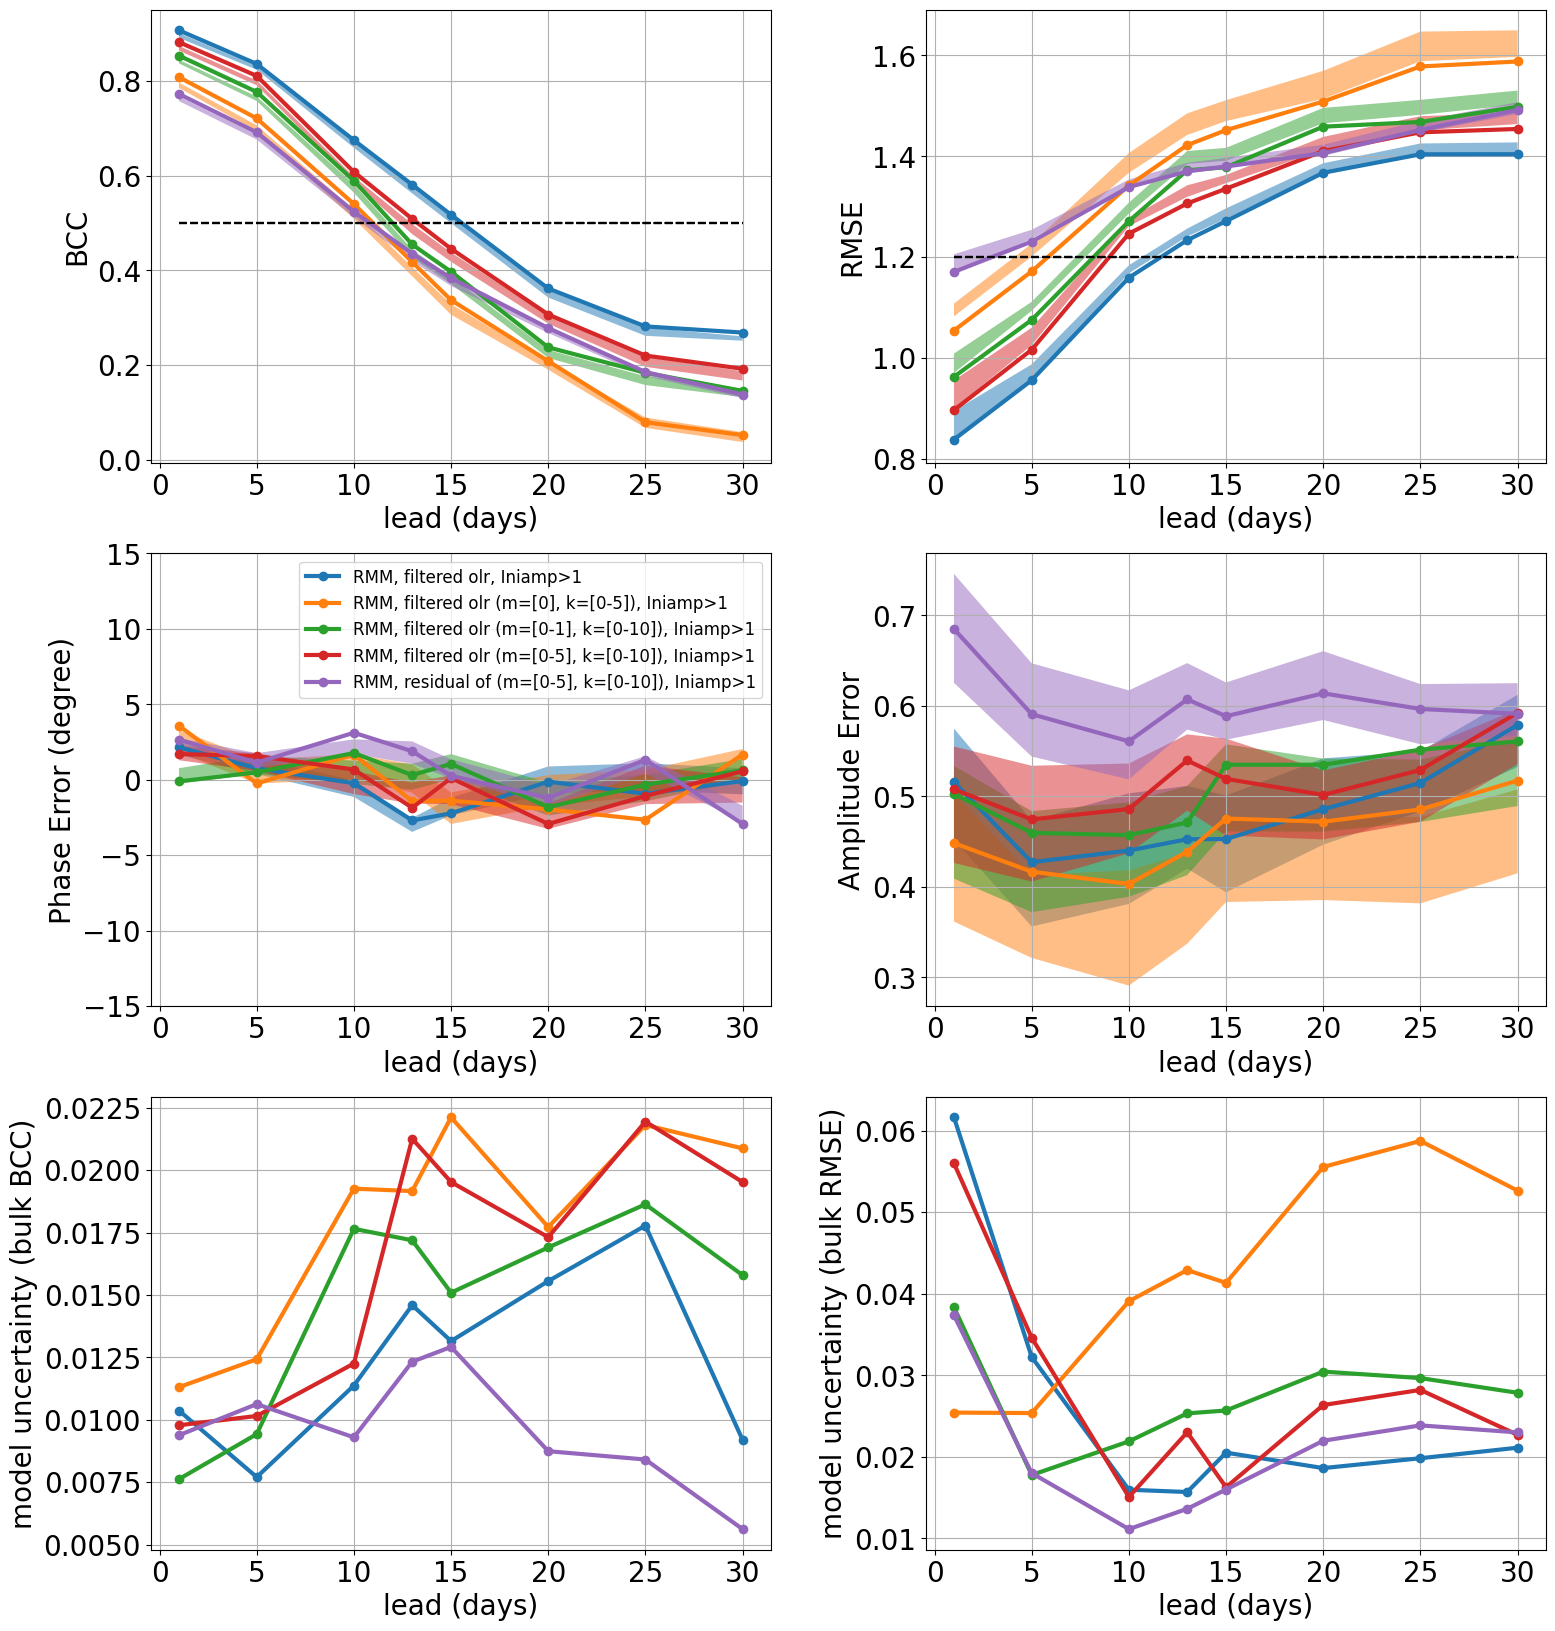

In [12]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2022
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 1
mflg = 'all'
wnx = 5
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 6
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 6
mflg = 'resi'
wnx = 10
wnxflg = 'resi'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', residual of (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))


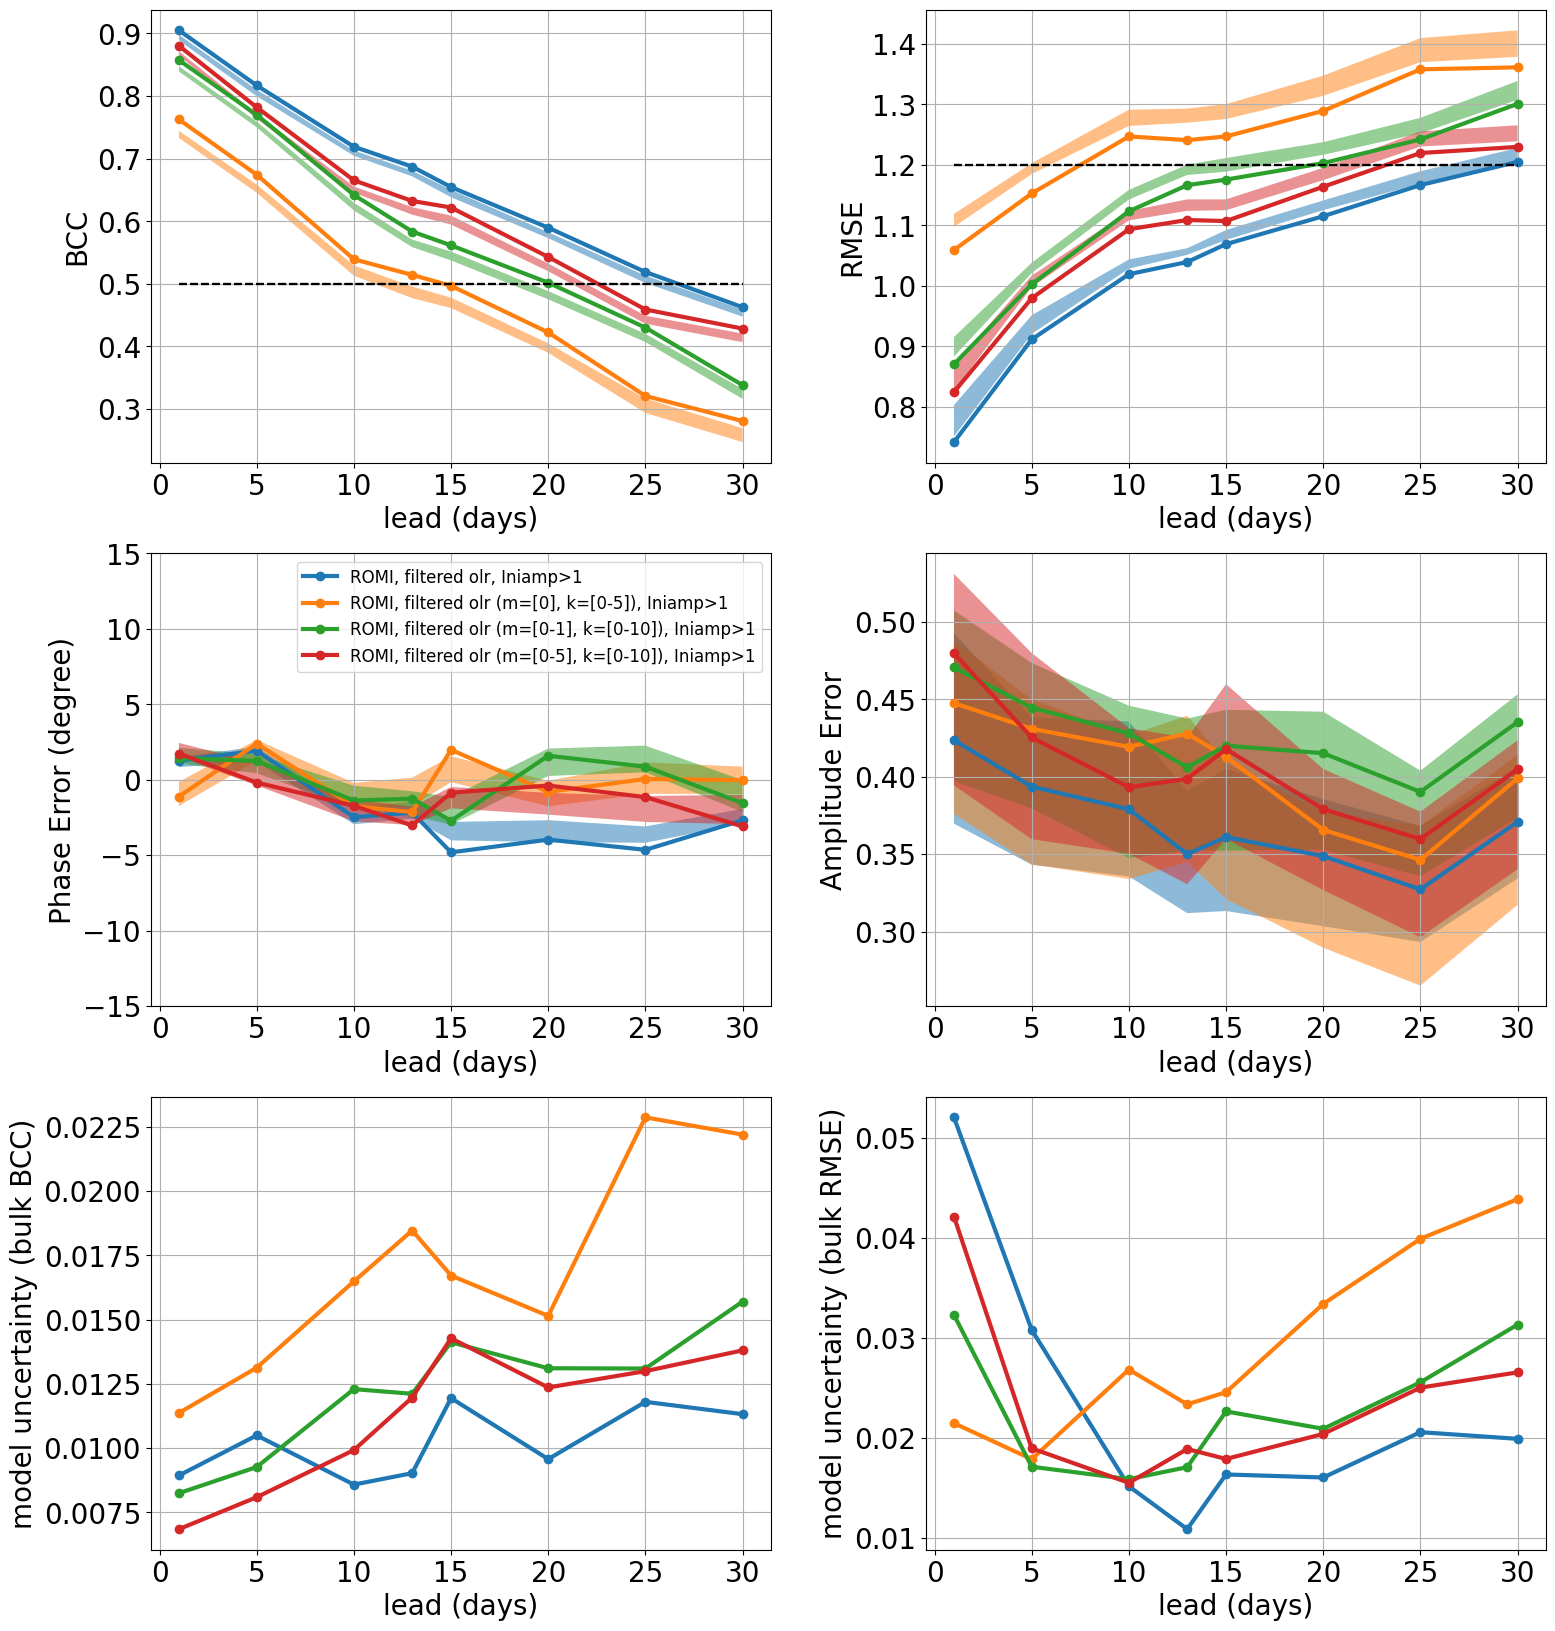

In [13]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'ROMI'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 1
mflg = 'all'
wnx = 5
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 6
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

# m = 6
# mflg = 'resi'
# wnx = 10
# wnxflg = 'resi'

# BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', residual of (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# # get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))


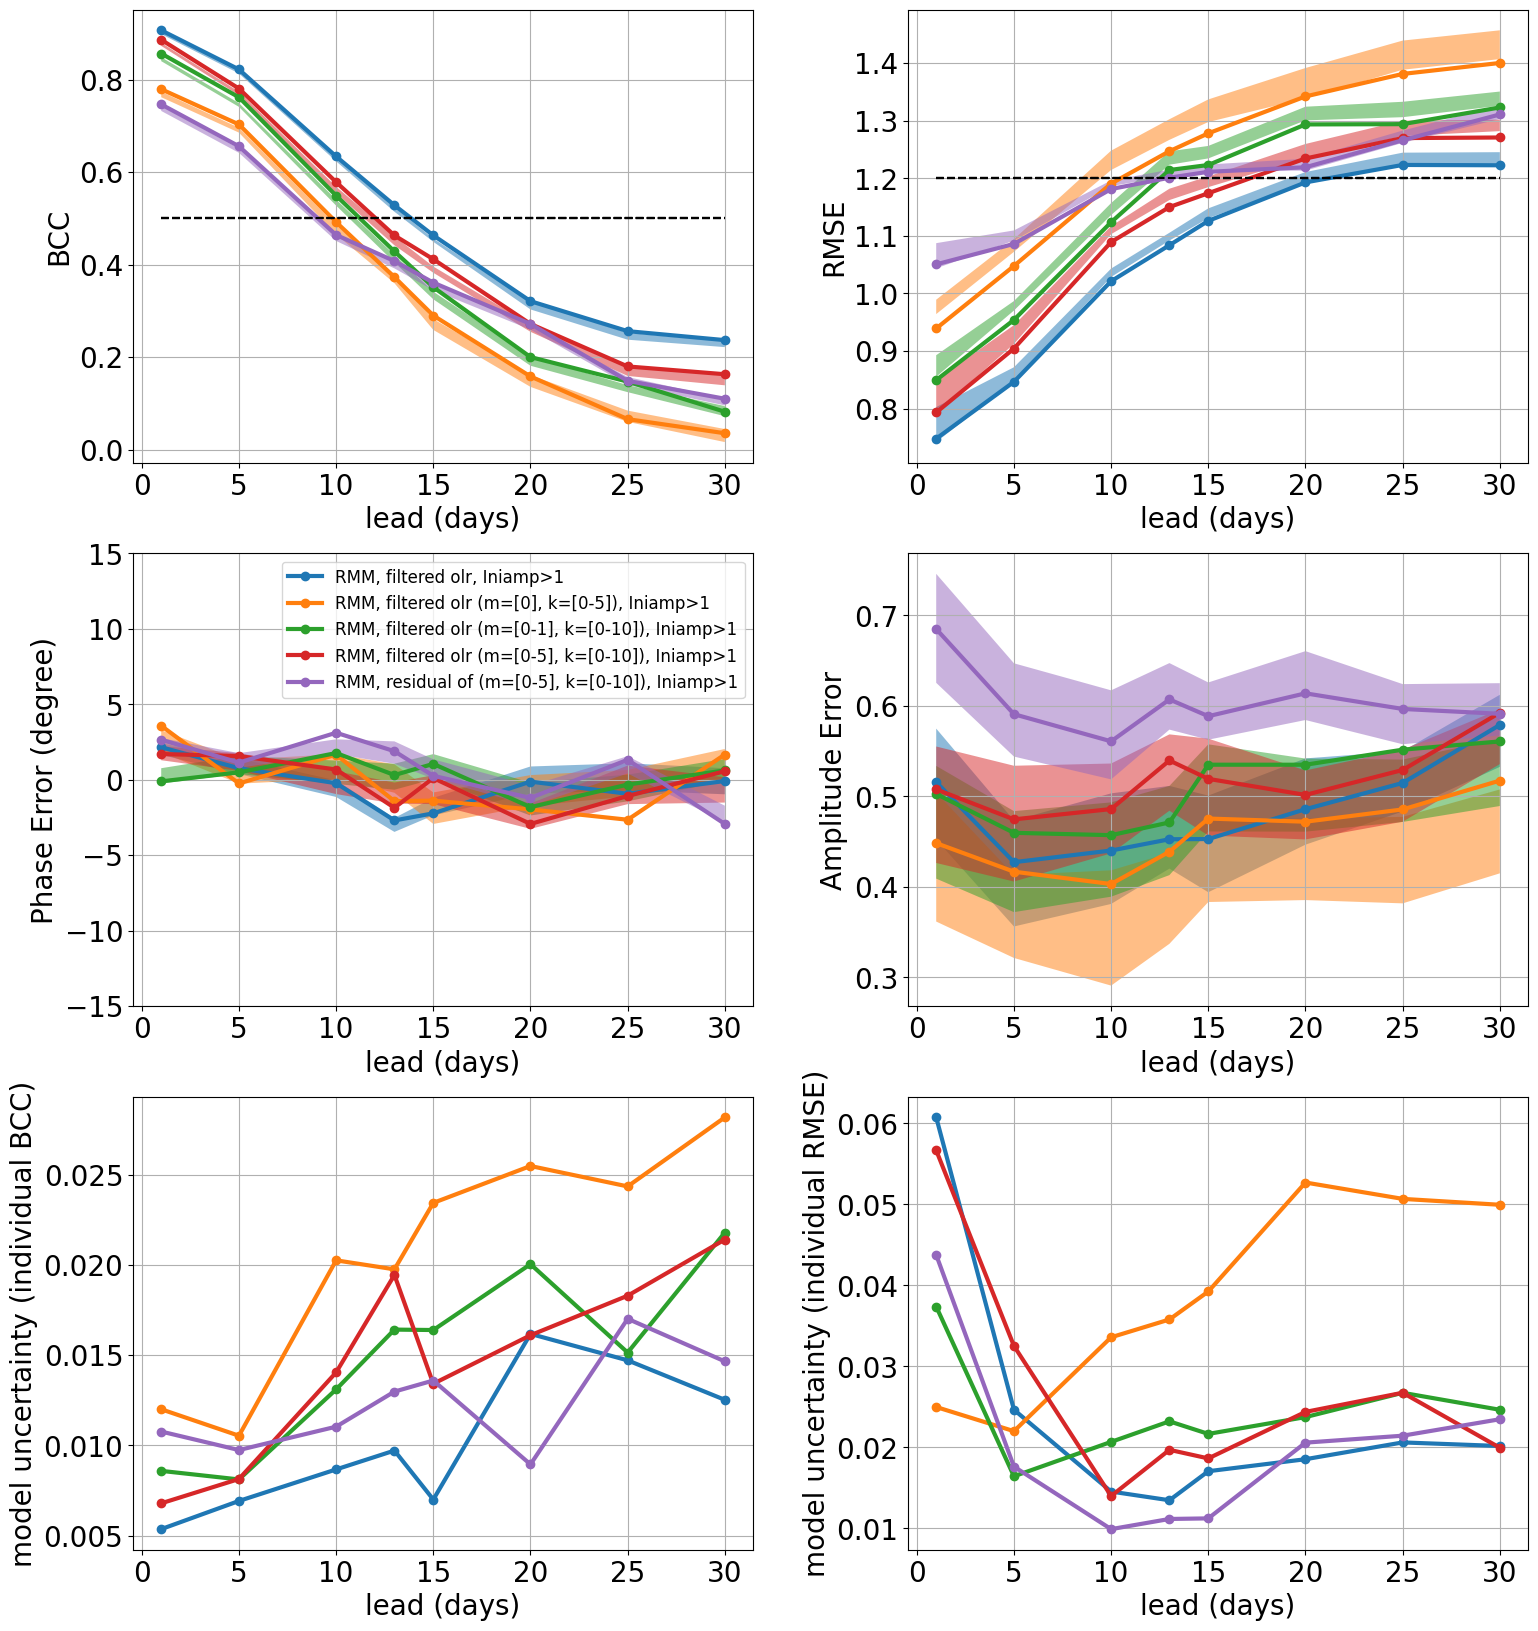

In [14]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+dataflg+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0))

m = 1
mflg = 'all'
wnx = 5
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))


m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))

m = 6
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))

m = 6
mflg = 'resi'
wnx = 10
wnxflg = 'resi'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', residual of (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))


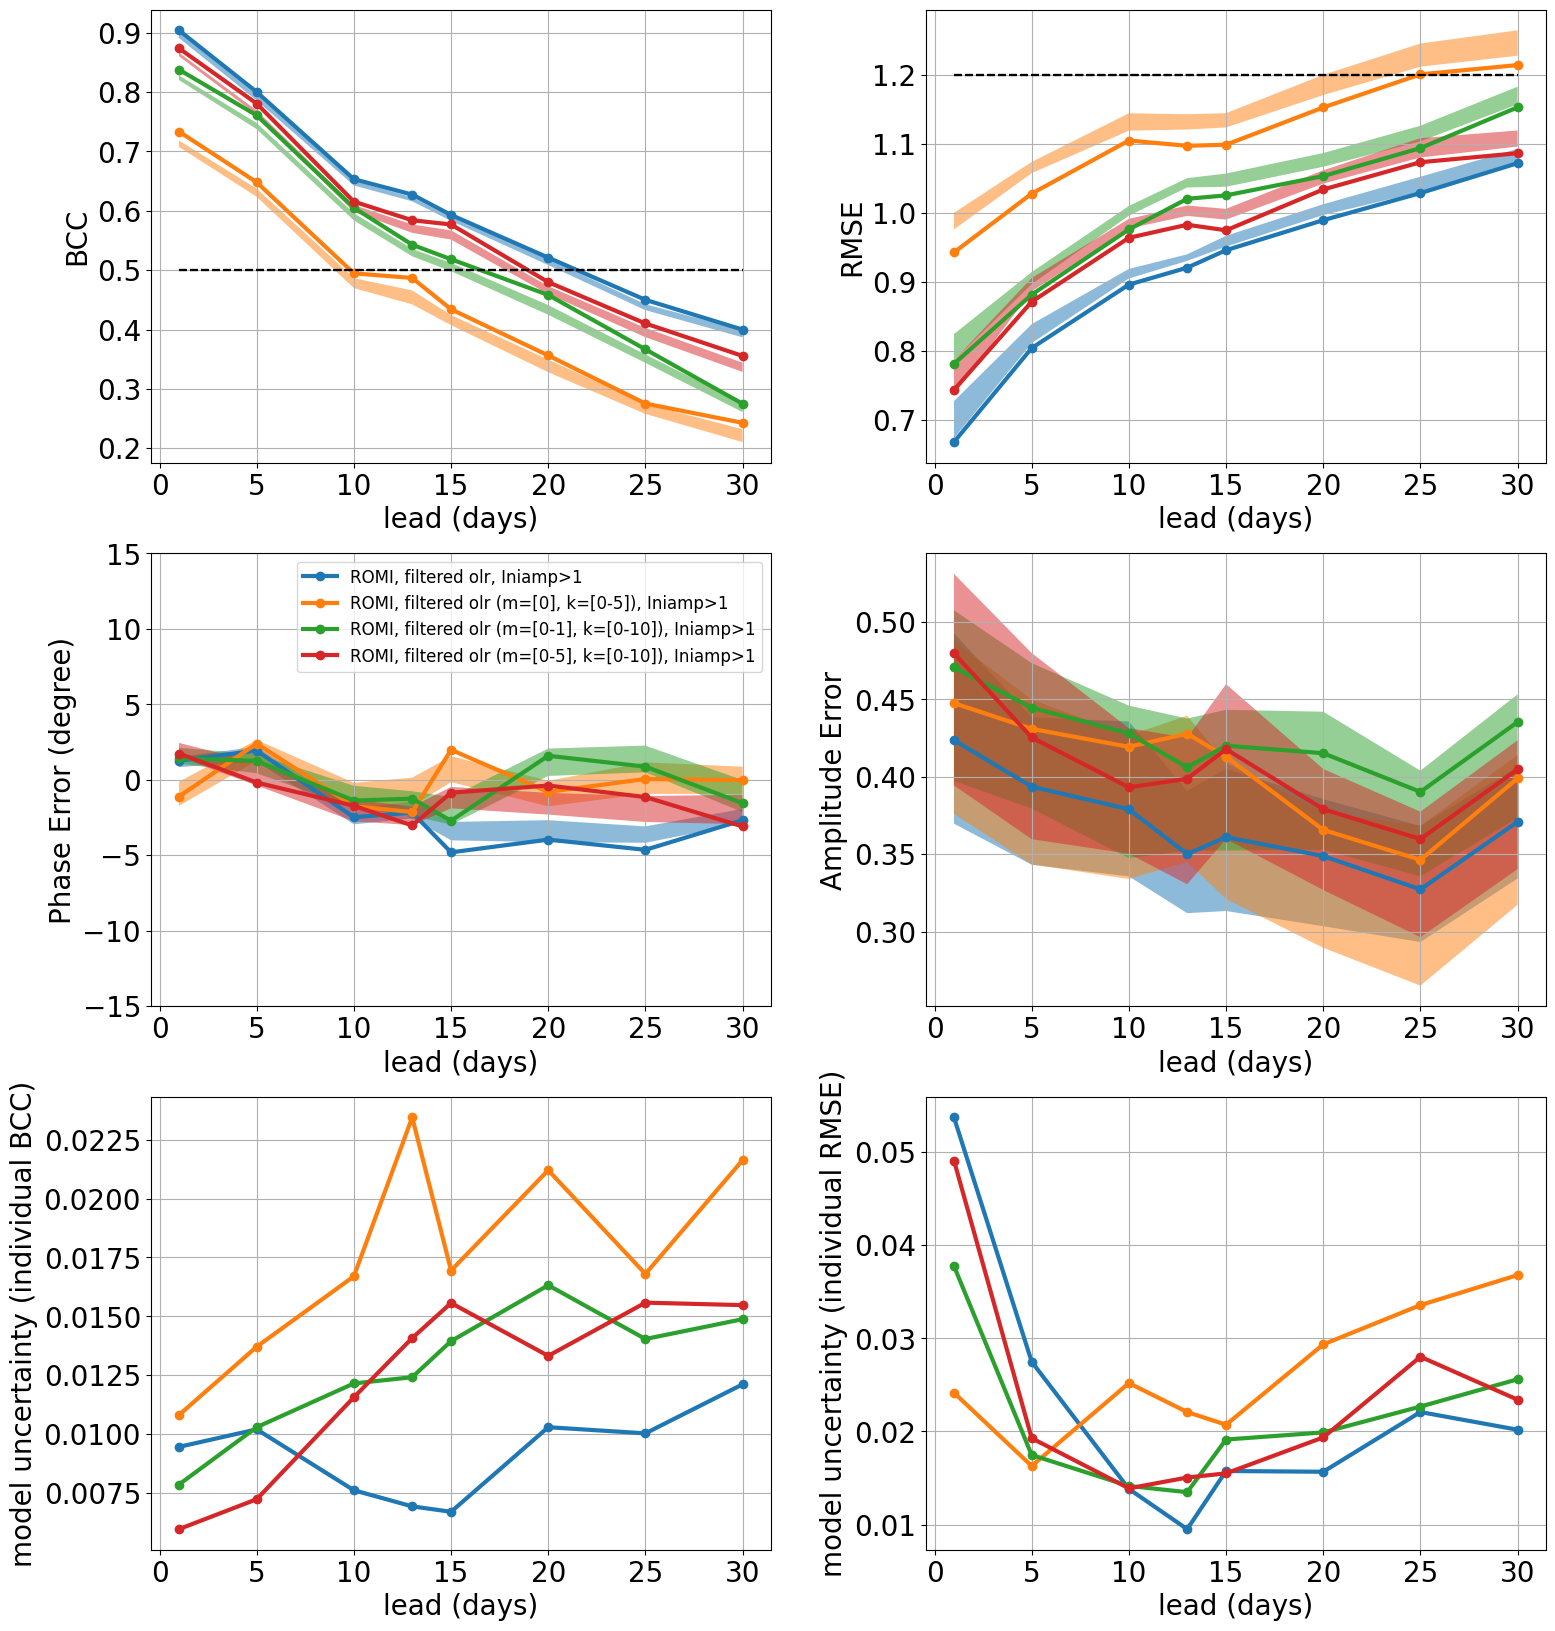

In [15]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'ROMI'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+dataflg+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0))

m = 1
mflg = 'all'
wnx = 5
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))

m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))

m = 6
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))


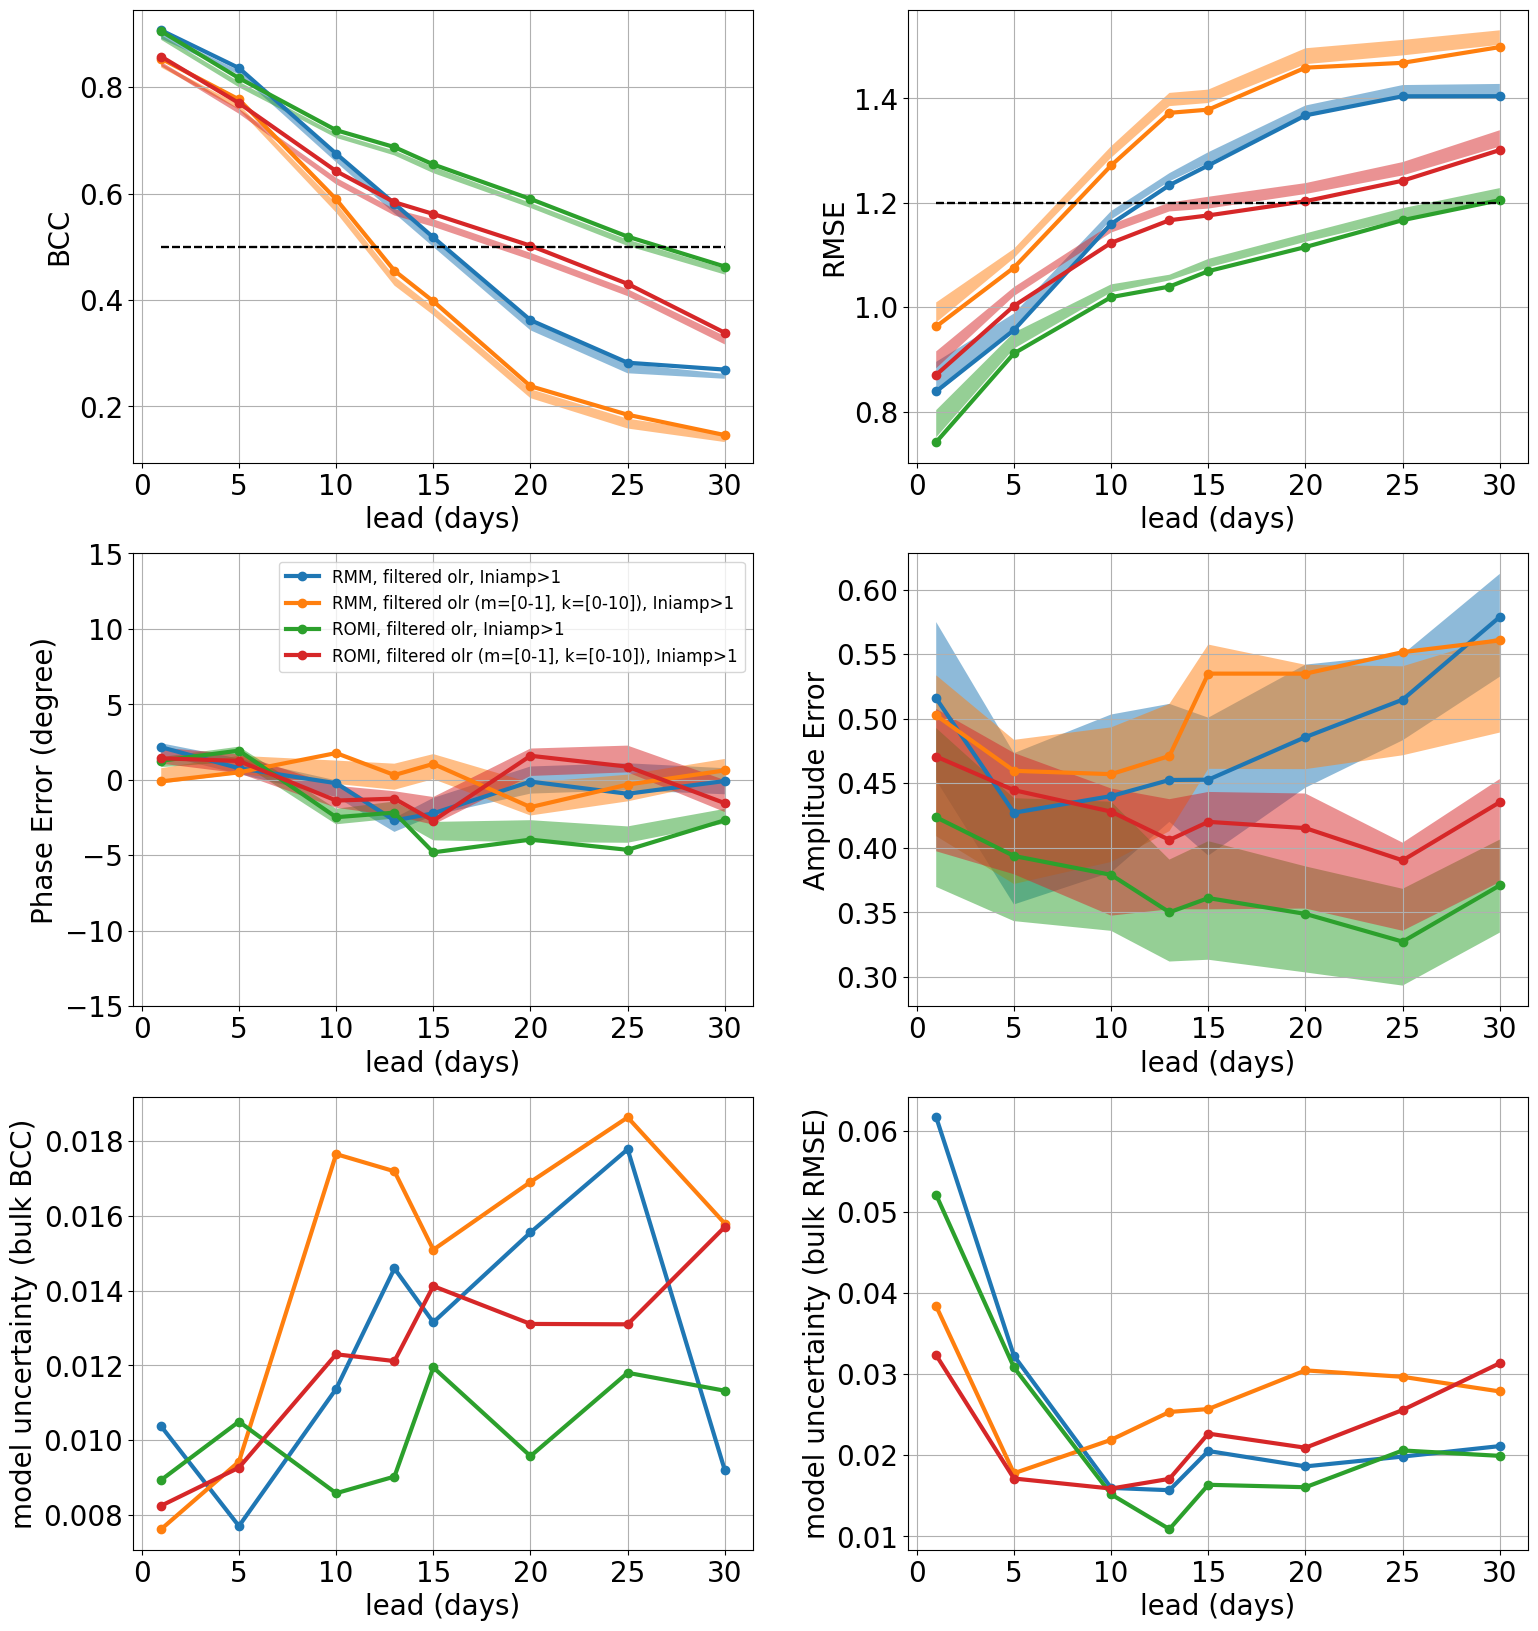

In [4]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'ROMI'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(18,20))
# gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
# ax = gs.subplots()
# plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))

m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))


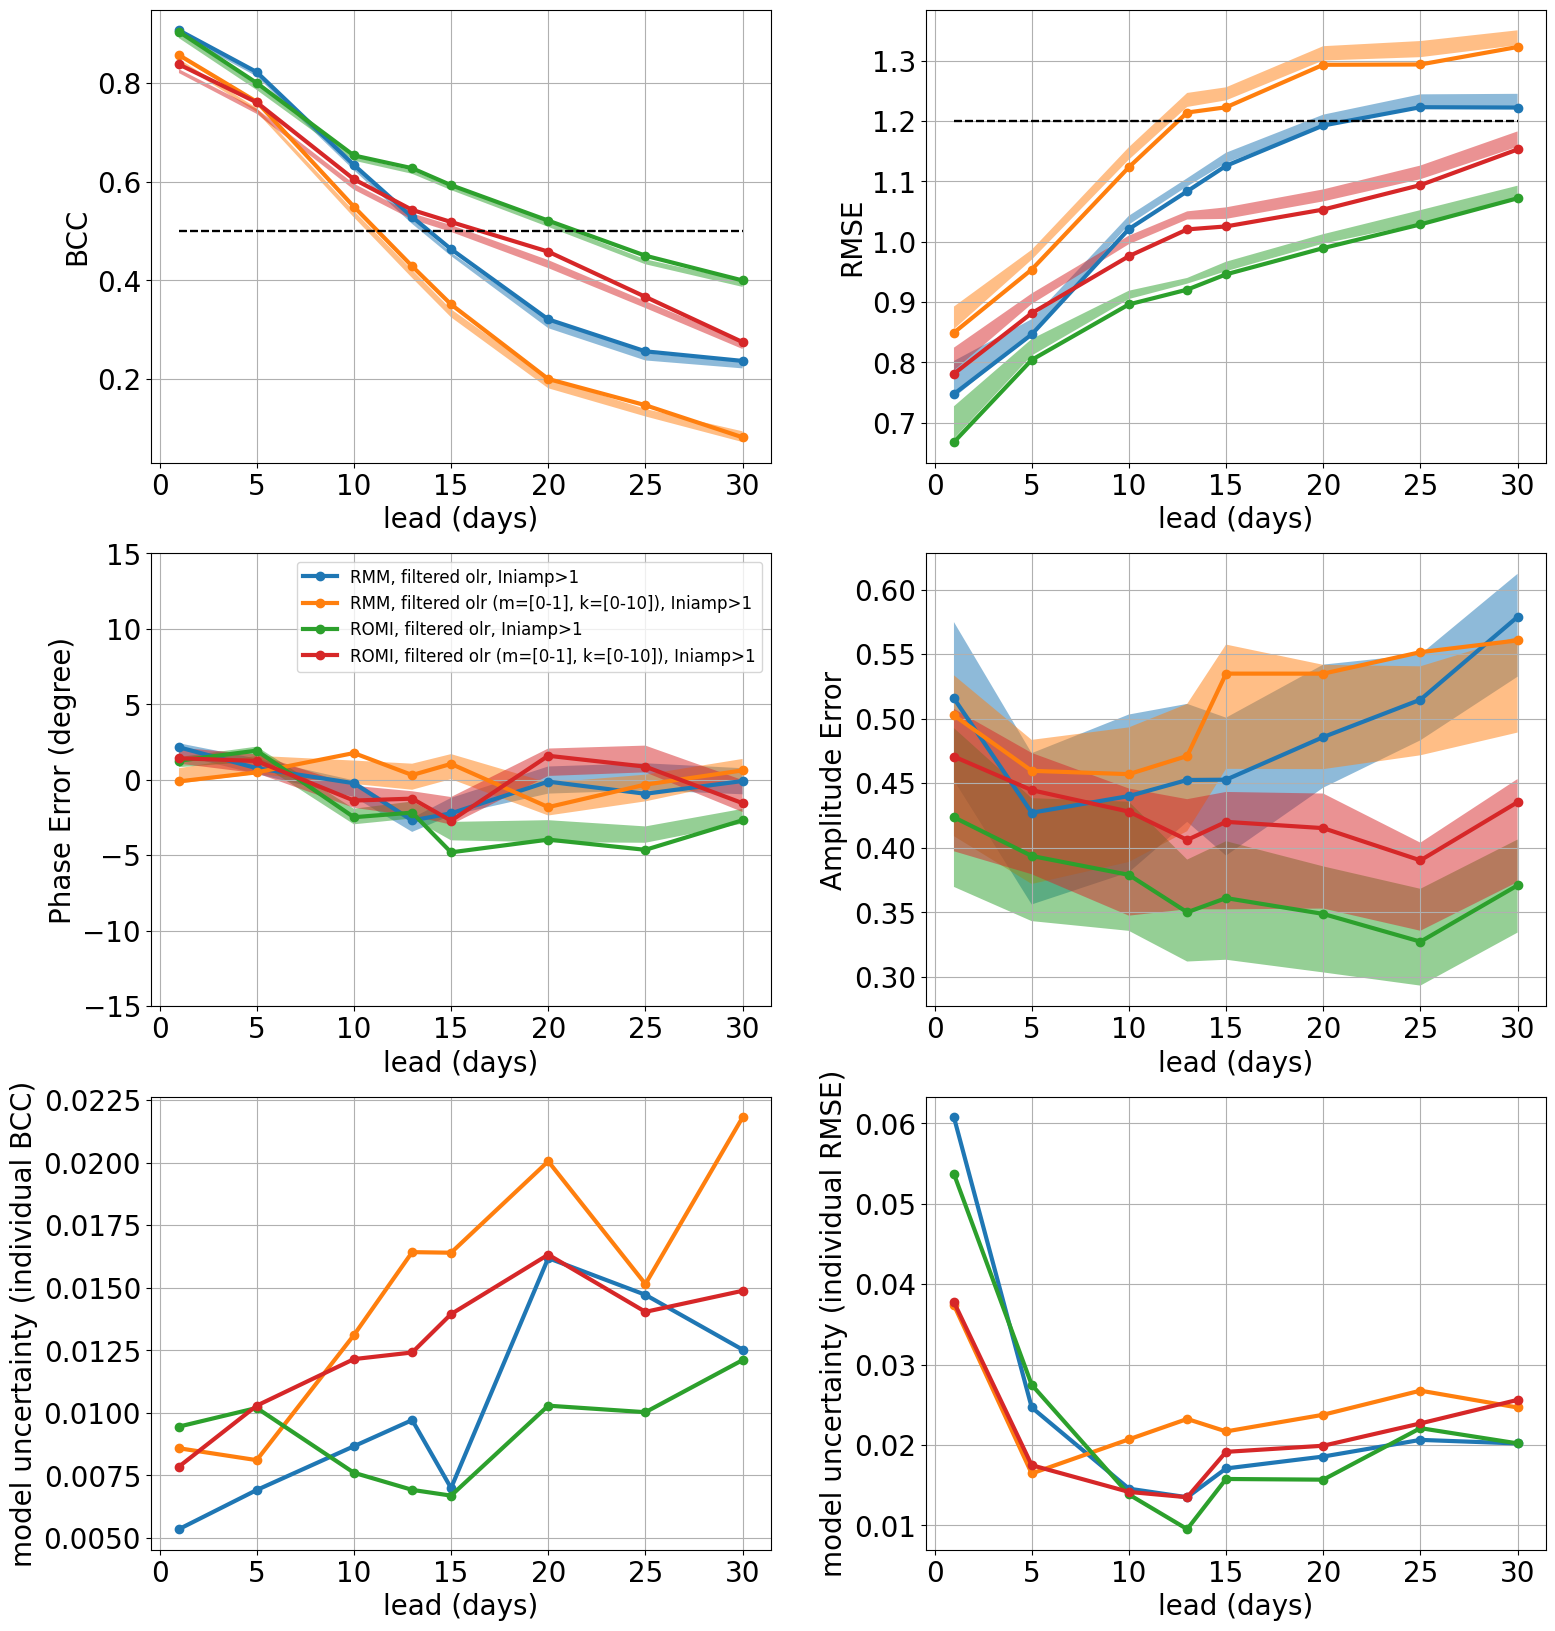

In [5]:
vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+dataflg+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0))


m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))

vn = 'olr'
dataflg = ''
lat_range = 20
mjo_ind = 'ROMI'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(18,20))
# gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.25)
# ax = gs.subplots()
# plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+dataflg+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+', Iniamp>'+str(Iniamp0))


m = 2
mflg = 'all'
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE_model_un(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, dataflg, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
# get_figure_q(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)
# get_figure_model_un(BCC, RMSE, pha_err, amp_err, ax, lead, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0))
get_figure_model_un(BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav, ax, lead, mjo_ind+', filtered '+vn+' (m=[0-'+str(m-1)+'], k=[0-'+str(wnx)+']), Iniamp>'+str(Iniamp0))


In [2]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [3]:
def get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    RMSEav = []
    amp_errav  = []
    pha_errav = []
    BCCav = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = tsta + np.timedelta64(1819, 'D')

    # RMM index in all seasons, amplitudes and phases.
    # fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    if mjo_ind=='RMM':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
    elif mjo_ind=='ROMI':
        Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/ROMI_ERA5_daily_1979to2021.nc'

    dsrmm0 = xr.open_dataset(Fnmjo)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm[mjo_ind][:,0]
    RMMi2 = dsrmm[mjo_ind][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus/output/predicted_MCDO_UNET_'+vn+str(lat_range)+'deg_'+mjo_ind+'ERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn[mjo_ind+'t'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))[mjo_ind].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC 
        r1p = np.asarray(dsfn_sel[mjo_ind+'p'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel[mjo_ind+'p'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel[mjo_ind+'t'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel[mjo_ind+'t'][:,1]).reshape((-1, 1))

        # BCC 
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCCav.append(a/b/c) 

        # RMSE [time]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSEav.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_errav.append(d)

        # amplitude error [time] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_errav.append(c)

        Nsamp = np.shape(dsfn_sel[mjo_ind+'p_dis'])[1]

        RMSEdp = []
        amp_errdp  = []
        pha_errdp = []
        BCCdp = []

        for idp in range(Nsamp):
            # calculate BCC 
            r1p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,idp,0]).reshape((-1, 1))
            r2p = np.asarray(dsfn_sel[mjo_ind+'p_dis'][:,idp,1]).reshape((-1, 1))

            # BCC 
            a = np.sum(r1p*r1t+r2p*r2t, axis=0)
            b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
            c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
            BCCdp.append(a/b/c) 

            # RMSE 
            d = np.sqrt((r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p))
            RMSEdp.append(np.mean(d))  

            # phase error 
            a = r1t * r2p - r2t * r1p 
            b = r1t * r1p + r2t * r2p
            c = a / b 
            d = np.arctan(c) * 180. / np.pi
            pha_errdp.append(np.mean(d))

            # amplitude error [time] truth - prediction
            a = np.sqrt(r1p*r1p+r2p*r2p)
            b = np.sqrt(r1t*r1t+r2t*r2t)
            c = b - a 
            amp_errdp.append(np.mean(c))

        BCC.append(BCCdp)
        RMSE.append(RMSEdp)
        amp_err.append(amp_errdp)
        pha_err.append(pha_errdp)
        
        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav

In [4]:
def get_figure(BCCdp, RMSEdp, pha_errdp, amp_errdp, ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].fill_between(lead, np.min(np.asarray(BCCdp),axis=1).squeeze(), np.max(np.asarray(BCCdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[0,1].fill_between(lead, np.min(np.asarray(RMSEdp),axis=1).squeeze(), np.max(np.asarray(RMSEdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,1].fill_between(lead, np.min(np.asarray(amp_errdp),axis=1).squeeze(), np.max(np.asarray(amp_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,0].fill_between(lead, np.min(np.asarray(pha_errdp),axis=1).squeeze(), np.max(np.asarray(pha_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

In [5]:
def get_figure_q(BCCdp, RMSEdp, pha_errdp, amp_errdp, ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    p1 = 25
    p2 = 75
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].fill_between(lead, np.percentile(np.asarray(BCCdp).squeeze(), p1, axis=1), np.percentile(np.asarray(BCCdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[0,1].fill_between(lead, np.percentile(np.asarray(RMSEdp).squeeze(),p1,axis=1), np.percentile(np.asarray(RMSEdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,1].fill_between(lead, np.percentile(np.asarray(amp_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(amp_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,0].fill_between(lead, np.percentile(np.asarray(pha_errdp).squeeze(),p1,axis=1), np.percentile(np.asarray(pha_errdp).squeeze(),p2,axis=1), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

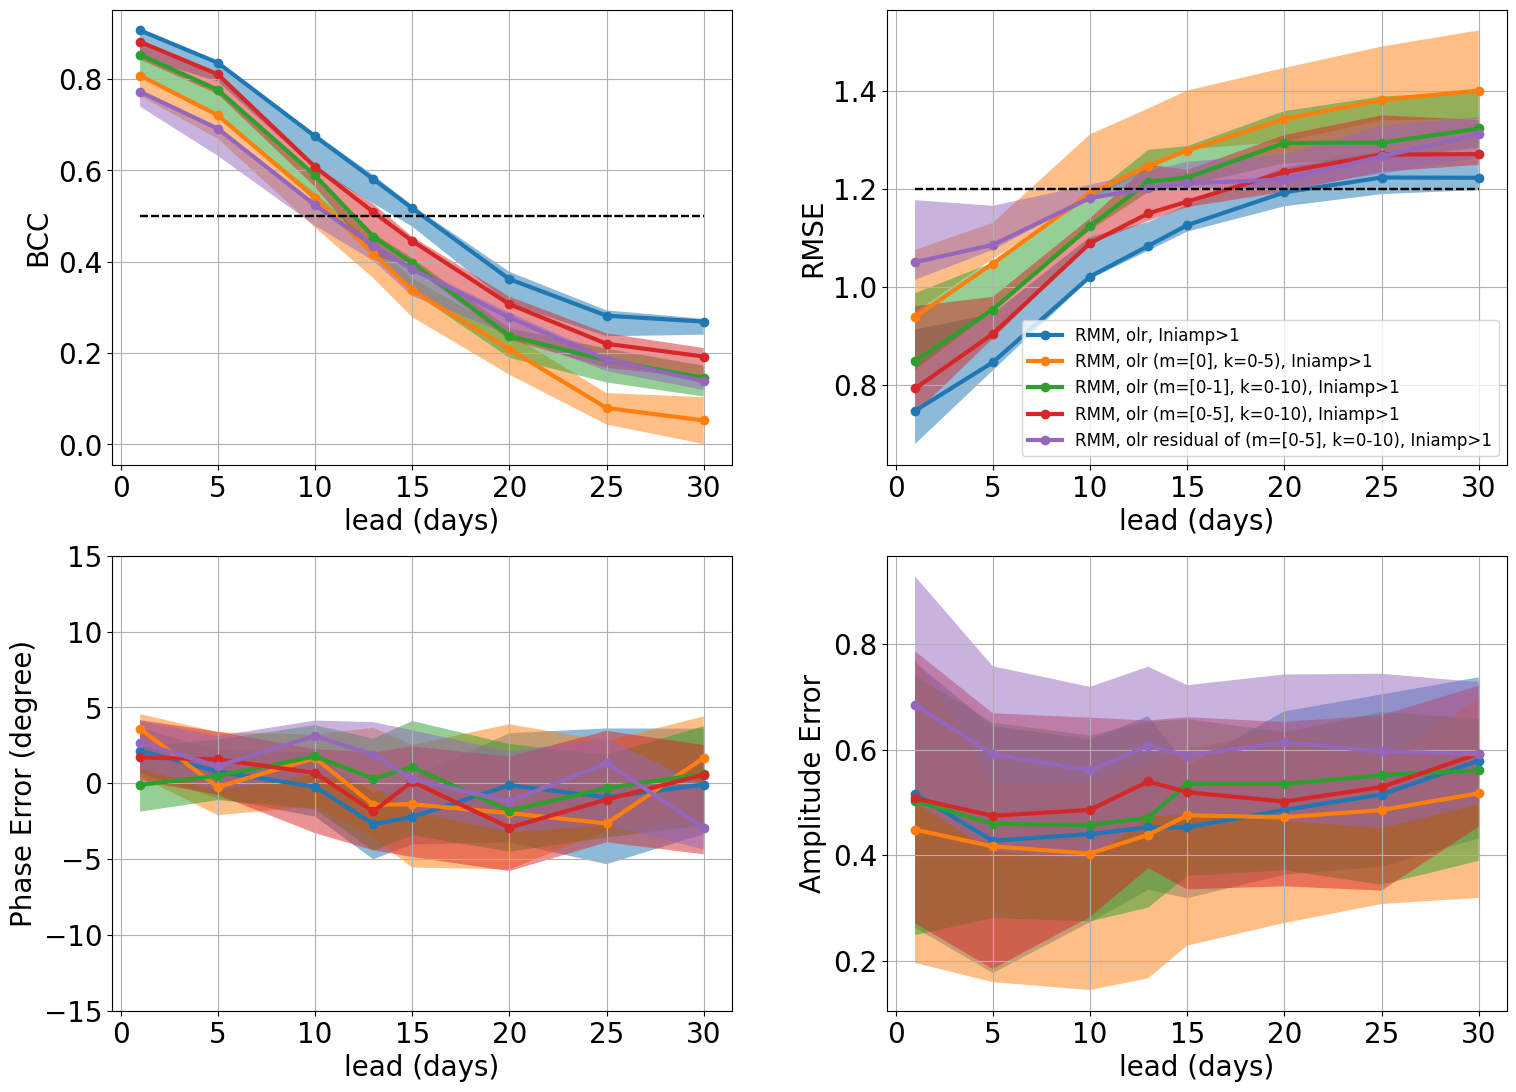

In [8]:
# calculate BCC for models using individual wnx (0,1,...,20)
vn = 'olr'
varn = "olr"
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
# lead = [1,5,10,13,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)

m = 1
mflg = 'all'
Iniamp0 = 1
wnx = 5
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+' (m=[0], k=0-'+str(wnx)+'), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)

m = 2
mflg = 'all'
Iniamp0 = 1
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+' (m=[0-'+str(m-1)+'], k=0-'+str(wnx)+'), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)

m = 6
mflg = 'all'
Iniamp0 = 1
wnx = 10
wnxflg = 'all'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+' (m=[0-'+str(m-1)+'], k=0-'+str(wnx)+'), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)

m = 6
mflg = 'resi'
Iniamp0 = 1
wnx = 10
wnxflg = 'resi'

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+' residual of (m=[0-'+str(m-1)+'], k=0-'+str(wnx)+'), Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)


In [ ]:
# calculate BCC for models using individual wnx (0,1,...,20)
# vn = 'olr'
varn = [
    "olr", "tcwv", "prep",
    "u200", "u500", "u850",  
    "q200", "q500", "q850", 
    "T200", "T500", "T850", 
    "Z200", "Z500", "Z850", 
    "v200", "v500", "v850", 
    "sst" # 

]
lat_range = 20
mjo_ind = 'ROMI'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(18,13))
# gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
# ax = gs.subplots()
# plt.rcParams.update({'font.size': 20})

BCC = []
RMSE = []
pha_err = []
amp_err = []
BCCav = []
RMSEav = []
pha_errav = []
amp_errav = []

for vn in varn:
    BCC0, RMSE0, pha_err0, amp_err0, BCCav0, RMSEav0, pha_errav0, amp_errav0  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))

    BCC.append(BCC0)
    RMSE.append(RMSE0)
    pha_err.append(pha_err0)
    amp_err.append(amp_err0)

    BCCav.append(BCCav0)
    RMSEav.append(np.mean(np.asarray(RMSEav0), axis=1))
    pha_errav.append(np.mean(np.asarray(pha_errav0), axis=1))
    amp_errav.append(np.mean(np.asarray(amp_errav0), axis=1))

    

Text(0, 0.5, 'BCC')

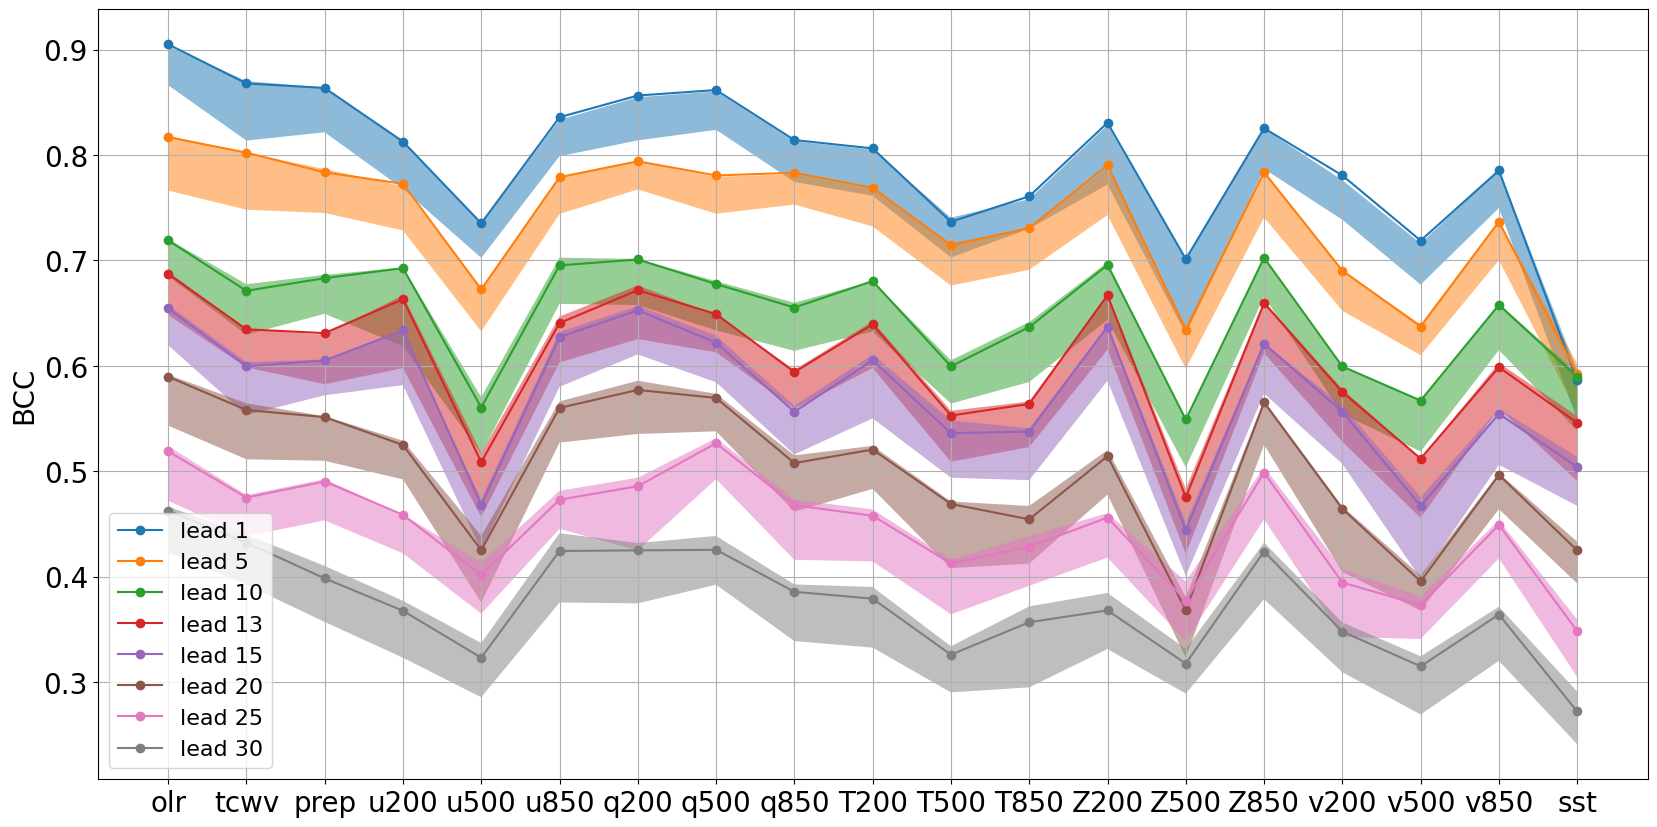

In [31]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 16})

BCCav = np.asarray(BCCav).squeeze()  # 19 var x 8 leads
BCC = np.asarray(BCC).squeeze()  # 19 var x 8 leads x 100 mcdp
BCCmax = np.max(BCC, axis=-1).squeeze()
BCCmin = np.min(BCC, axis=-1).squeeze()

for i, ilead in enumerate(lead[:]):
    ax.plot(range(1,20), BCCav[:,i],'o-', label='lead '+str(ilead))
    ax.fill_between(range(1,20), BCCmin[:,i], BCCmax[:,i], alpha=0.5)

ax.legend()
ax.set_xticks(range(1,20))
ax.set_xticklabels(varn)
ax.grid(visible=True)
ax.set_ylabel('BCC')

Text(0, 0.5, 'RMSE')

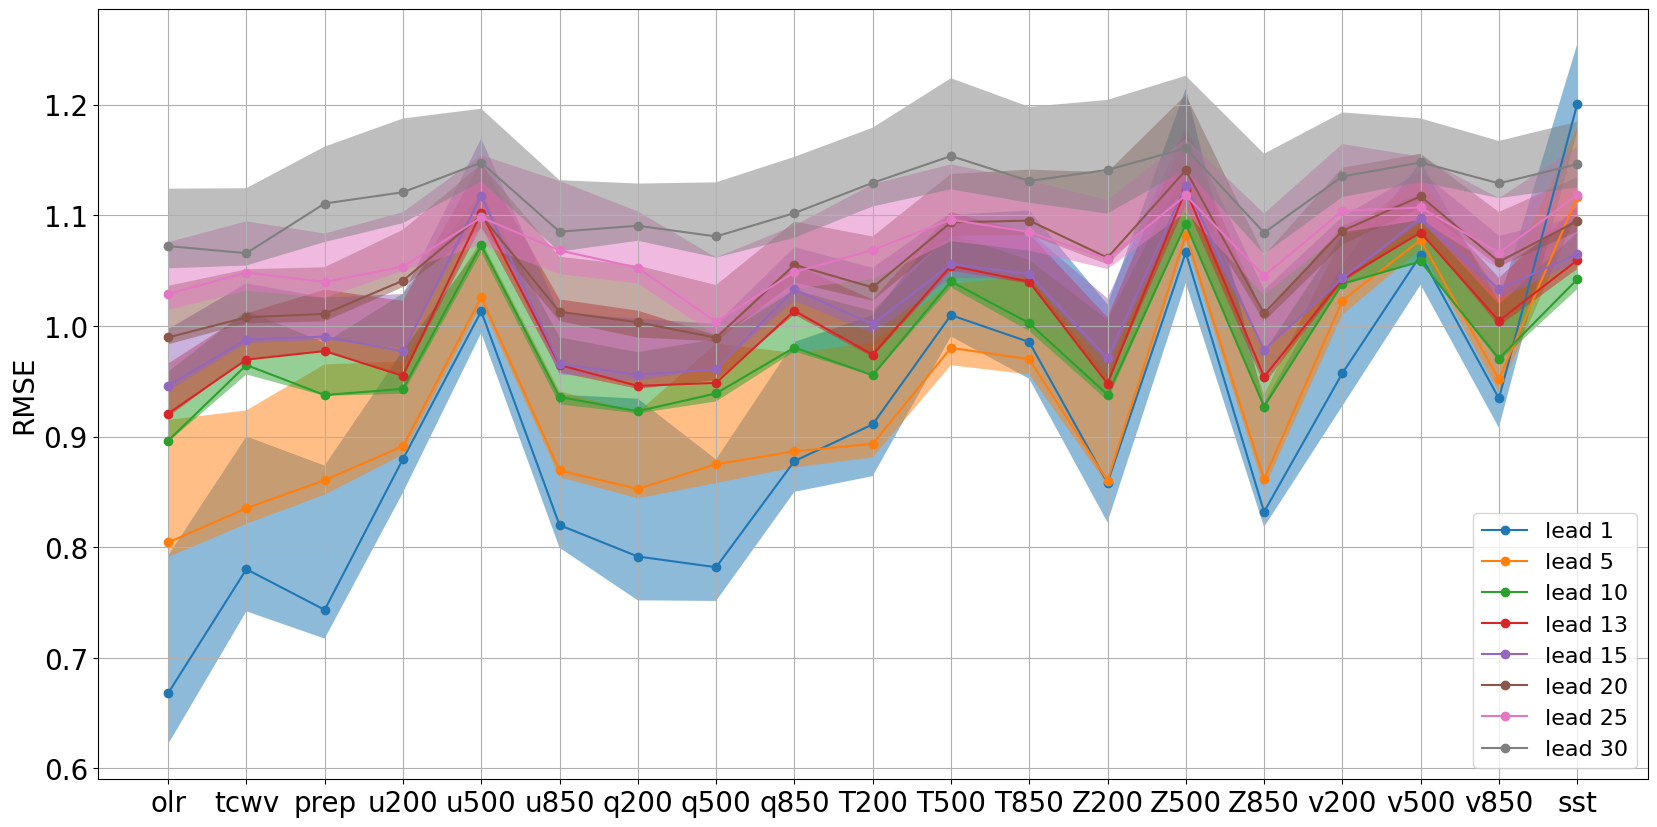

In [32]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 16})

RMSEav = np.asarray(RMSEav).squeeze()  # 19 var x 8 leads
RMSE = np.asarray(RMSE).squeeze()  # 19 var x 8 leads x 100 mcdp
RMSEmax = np.max(RMSE, axis=-1).squeeze()
RMSEmin = np.min(RMSE, axis=-1).squeeze()

for i, ilead in enumerate(lead[:]):
    ax.plot(range(1,20), RMSEav[:,i],'o-', label='lead '+str(ilead))
    ax.fill_between(range(1,20), RMSEmin[:,i], RMSEmax[:,i], alpha=0.5)

ax.legend()
ax.set_xticks(range(1,20))
ax.set_xticklabels(varn)
ax.grid(visible=True)
ax.set_ylabel('RMSE')

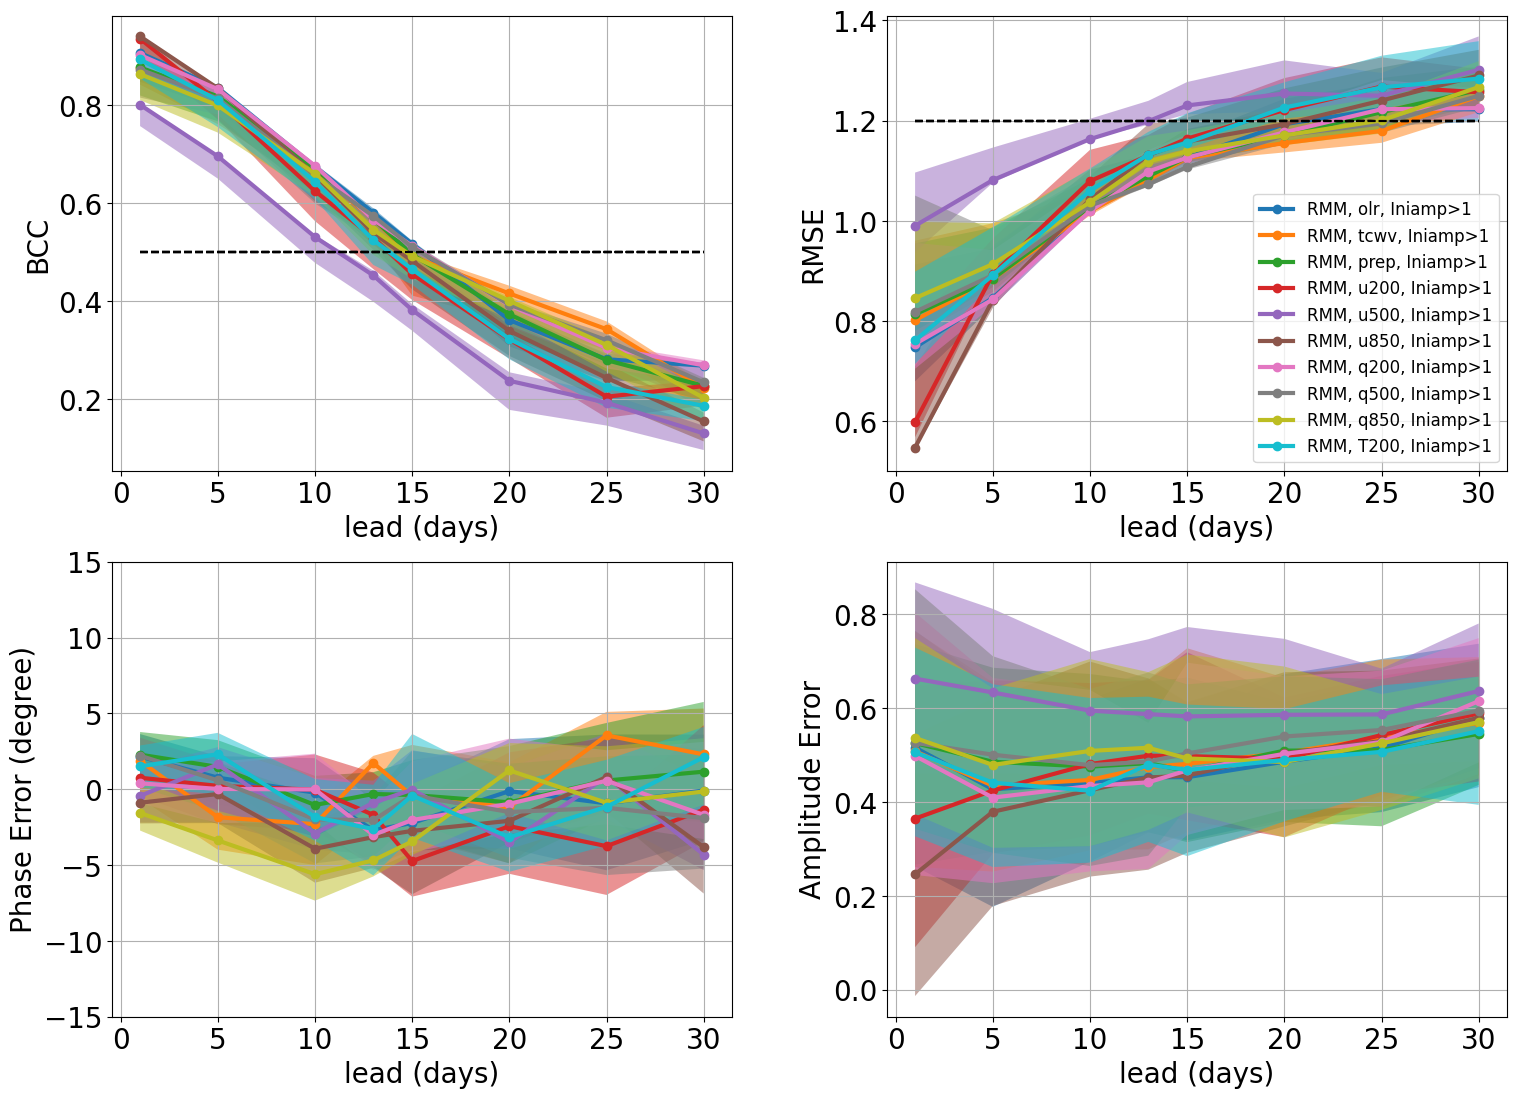

In [5]:
# calculate BCC for models using individual wnx (0,1,...,20)
# vn = 'olr'
varn = [
    "olr", "tcwv", "prep",
    "u200", "u500", "u850",  
    "q200", "q500", "q850", 
    "T200", "T500", "T850", 
    "Z200", "Z500", "Z850", 
    "v200", "v500", "v850", 
    "sst" # 

]
lat_range = 20
mjo_ind = 'RMM'
lead = [1,5,10,13,15,20,25,30]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
Iniamp0 = 1
wnx = 1 
wnxflg = 'off'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for vn in varn[:10]:
    BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)



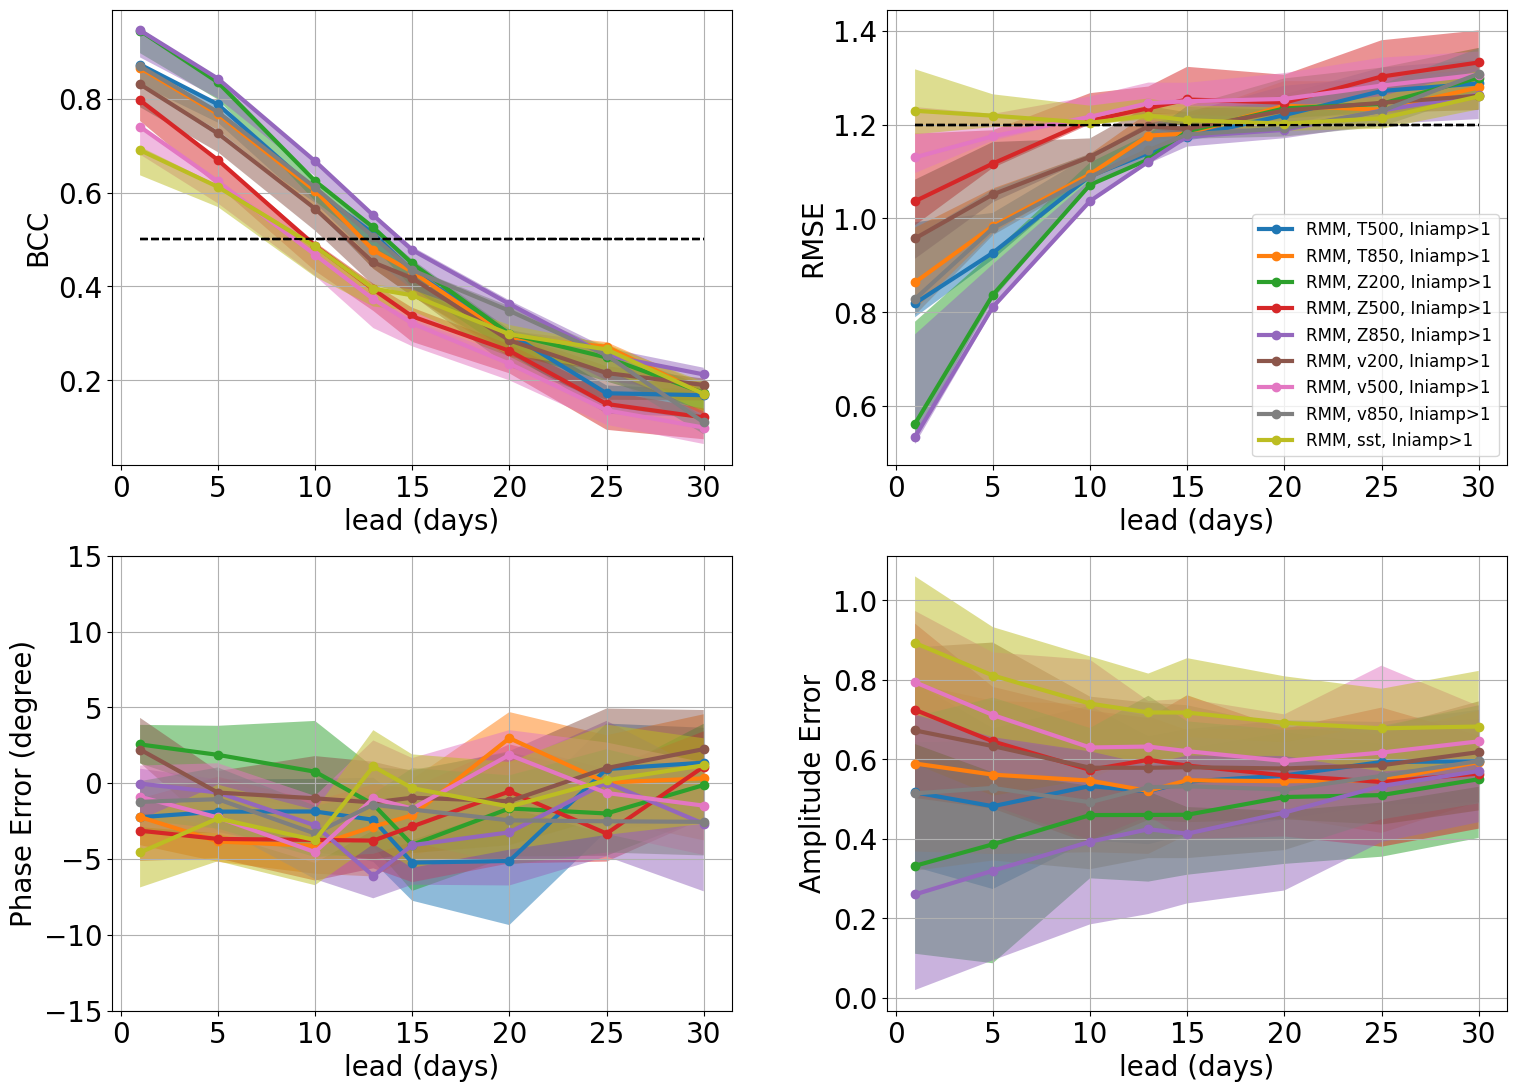

In [6]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for vn in varn[10:]:
    BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)


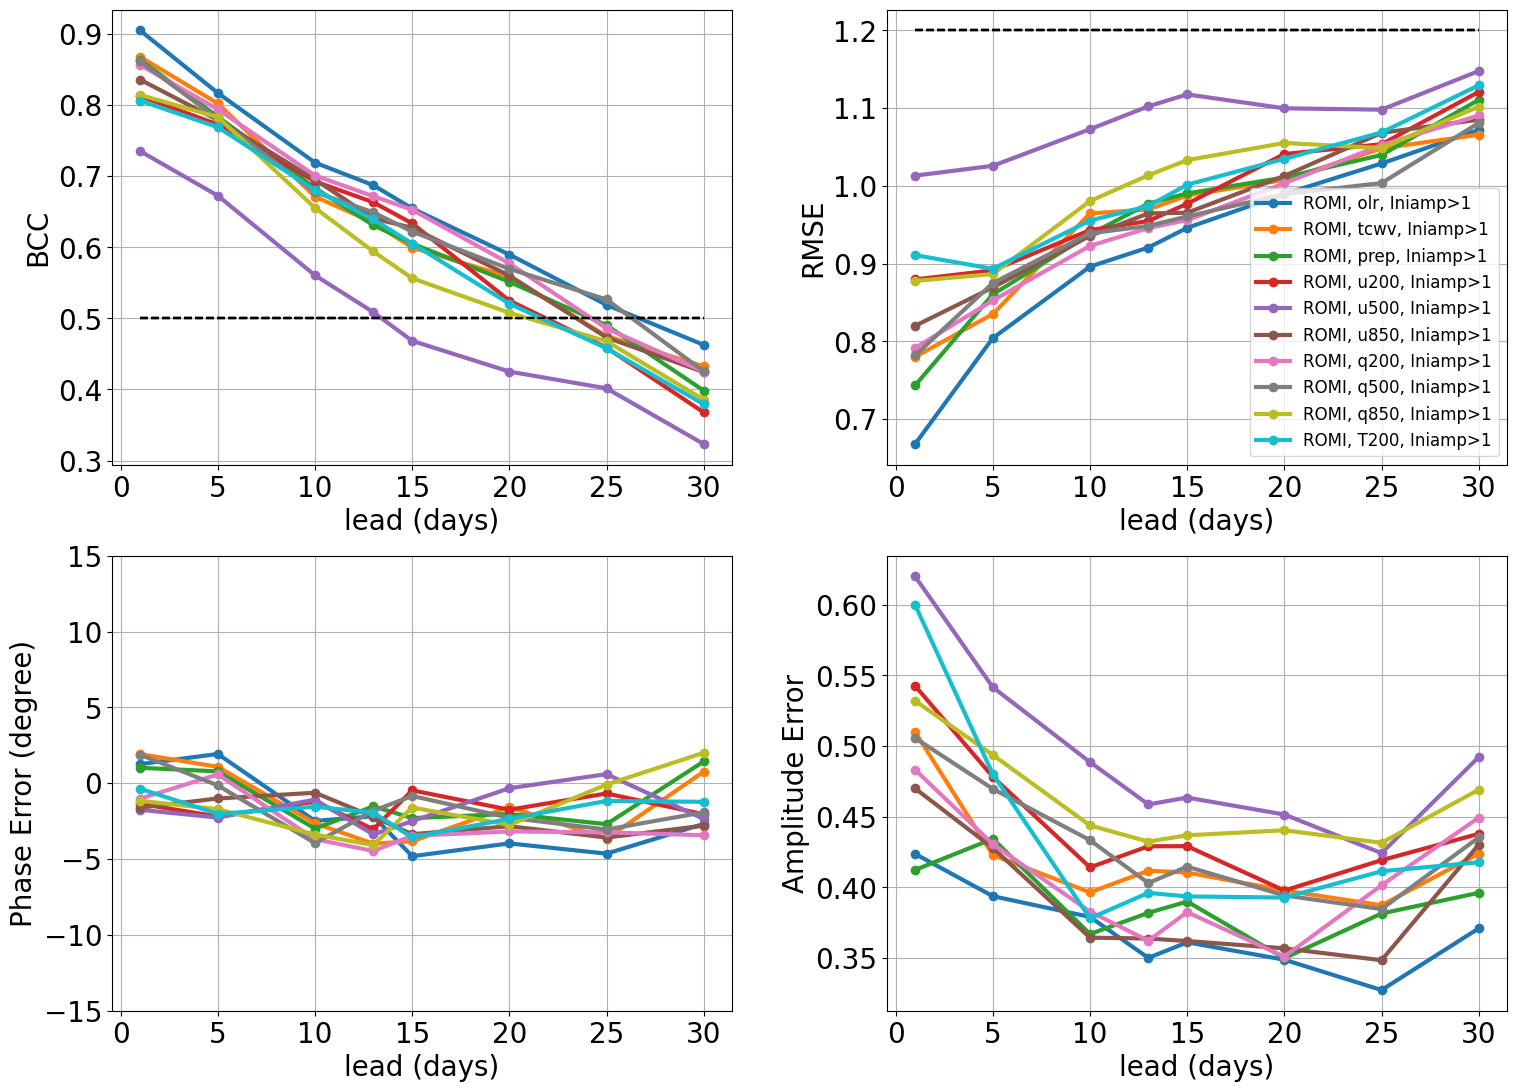

In [9]:
mjo_ind = 'ROMI'
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for vn in varn[:10]:
    BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)


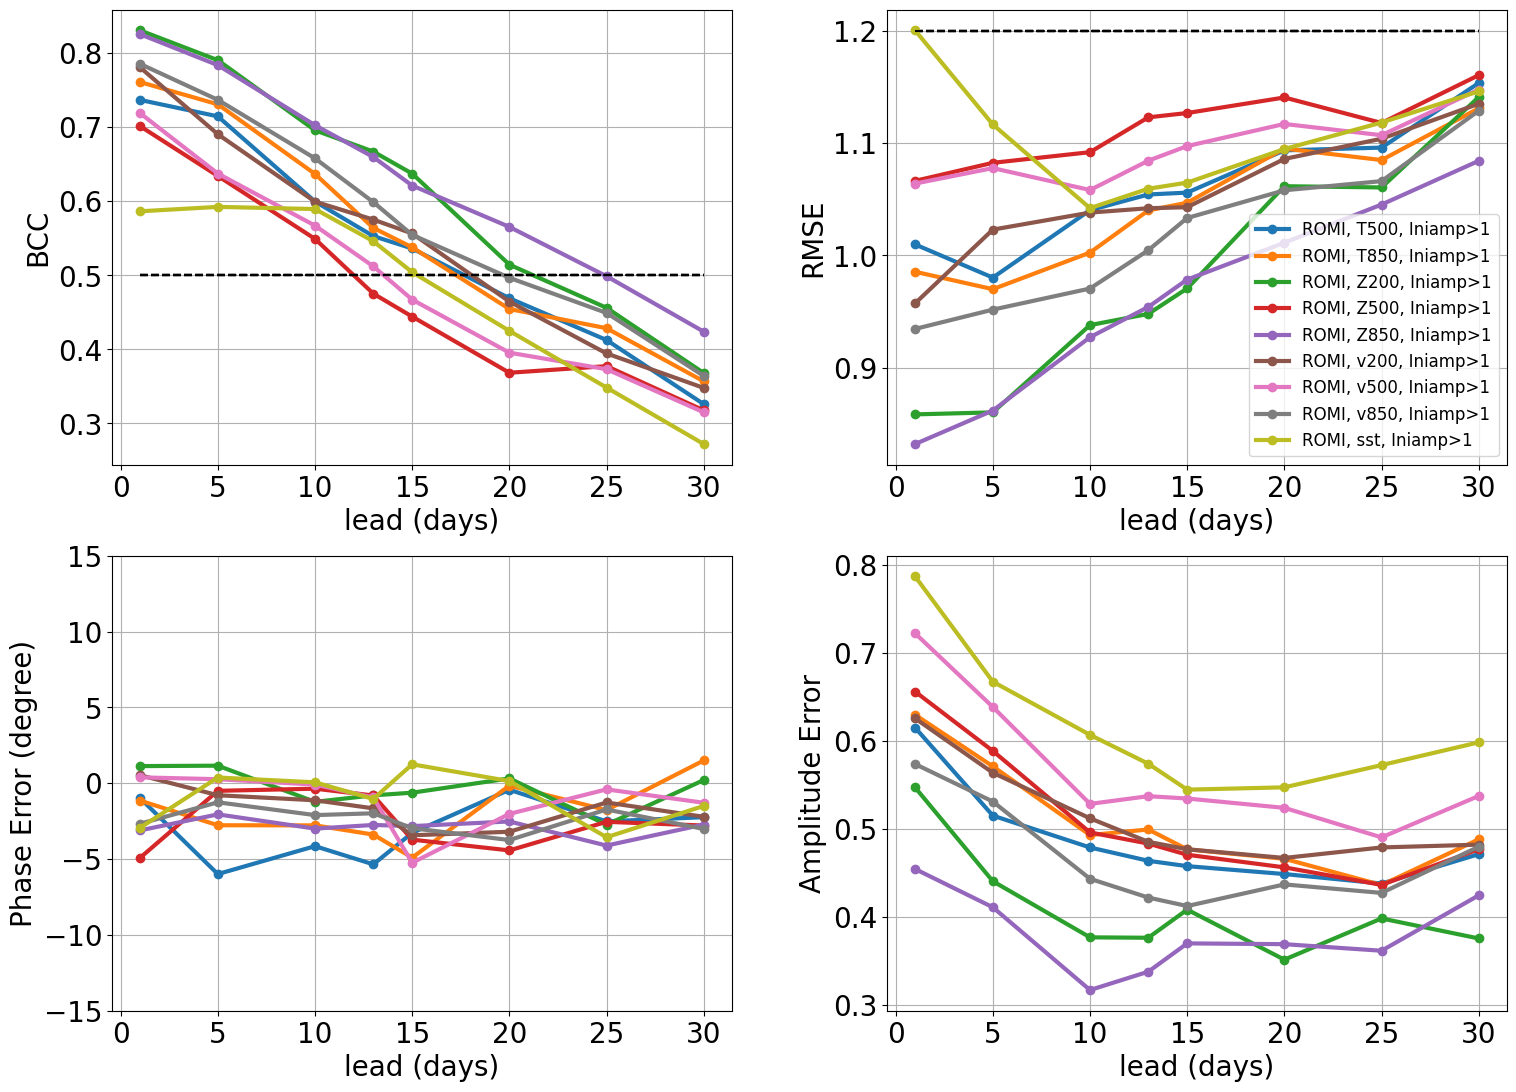

In [10]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.25)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for vn in varn[10:]:
    BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav  = get_BCC_RMSE(vn, lat_range, mjo_ind, m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, mjo_ind+', '+vn+', Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)


Text(0.5, 1.0, 'RMM2 2015, nmem=1, 1modesoff_wnx1off_lead10')

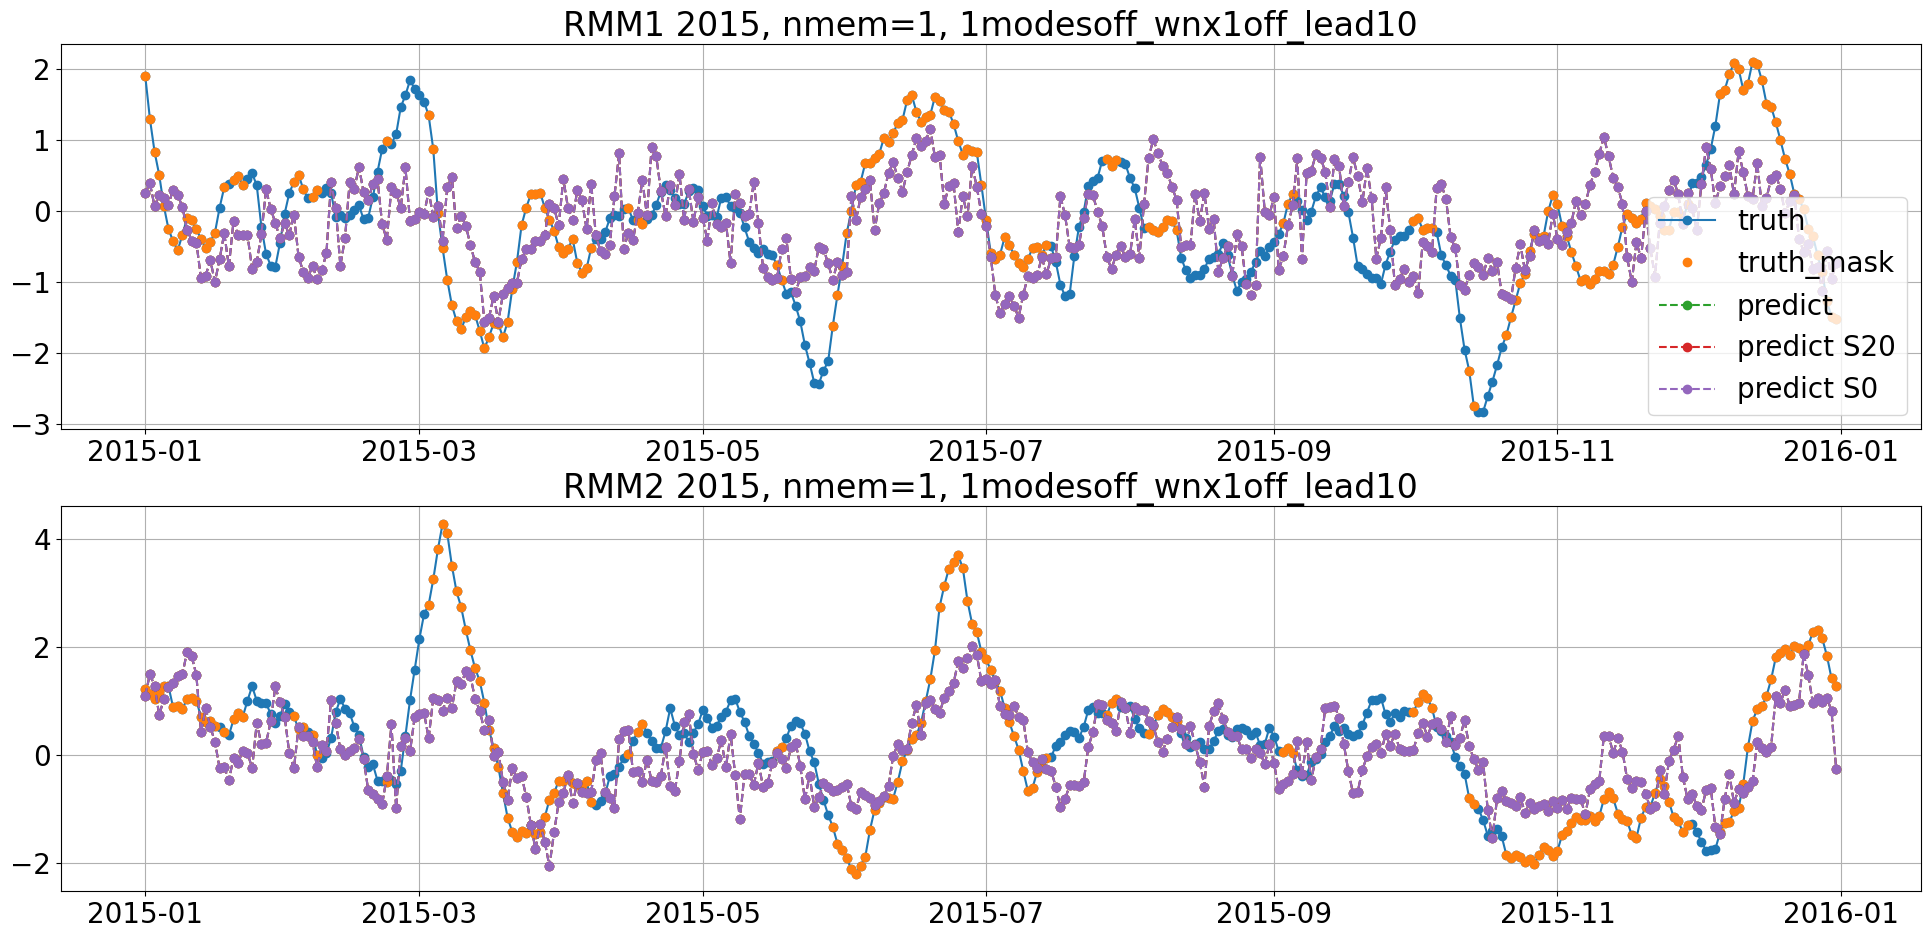

In [35]:
# show individual predictions
yr = 2015
leadmjo = 10

fn = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus/output/predicted_MCDO_UNET_'+vn+str(lat_range)+'deg_'+mjo_ind+'ERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'
ds = xr.open_dataset(fn)

ds15 = ds.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))

# mark points where Iniamp > 1

# define the selected time series, inclusive
tsta = np.datetime64(str(yr)) + np.timedelta64(nmem-1, 'D')
tend = np.datetime64(str(yr+1)) - np.timedelta64(1, 'D')

# RMM index in all seasons, amplitudes and phases.
fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
dsrmm0 = xr.open_dataset(fnRMM)
# delete doy 366
# dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
dsrmm = dsrmm0.sel(time=slice(tsta, tend))

RMMi1 = dsrmm['RMM'][:,0]
RMMi2 = dsrmm['RMM'][:,1]

# calculate initial amplitude
Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

ds15 = ds15.assign(IniAmp=Iniamp)

mask_Iniamp = ds15.IniAmp >= Iniamp0
ds15_mask = ds15.where(mask_Iniamp)

fig = plt.figure(figsize=(24,11))
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

ax[0].plot(ds15['time'], ds15['RMMt'][:,0],'o-', label='truth')
ax[0].plot(ds15_mask['time'], ds15_mask['RMMt'][:,0],'o', label='truth_mask')
ax[0].plot(ds15['time'], ds15['RMMp'][:,0],'o--', label='predict')
ax[0].plot(ds15['time'], ds15['RMMp_dis'][:,20,0],'o--', label='predict S20')
ax[0].plot(ds15['time'], ds15['RMMp_dis'][:,0,0],'o--', label='predict S0')
ax[0].legend()
ax[0].grid(visible=True)
ax[0].set_title('RMM1 '+ str(yr)+ ', nmem='+str(nmem)+', '+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo))

ax[1].plot(ds15['time'], ds15['RMMt'][:,1],'o-', label='truth')
ax[1].plot(ds15_mask['time'], ds15_mask['RMMt'][:,1],'o', label='truth_mask')
ax[1].plot(ds15['time'], ds15['RMMp'][:,1],'o--', label='predict')
ax[1].plot(ds15['time'], ds15['RMMp_dis'][:,20,1],'o--', label='predict S20')
ax[1].plot(ds15['time'], ds15['RMMp_dis'][:,0,1],'o--', label='predict S0')
# ax[1].legend()
ax[1].grid(visible=True)
ax[1].set_title('RMM2 '+ str(yr) + ', nmem='+str(nmem)+', '+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo))